# CODEX analyses

## Imports and data loading

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
# from pathlib3x import Path
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import loguniform

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [3]:
RUN_LONG = False

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [4]:
data_dir = Path("../data/raw/CODEX_CTCL")
try:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.jbl"
    obj = joblib.load(objects_path)
except FileNotFoundError:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"
    obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [5]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y'] # no z this time ! 
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [6]:
obj.shape

(117170, 121)

In [7]:
obj[['FileName', 'Patients', 'Count']].groupby(['Patients', 'FileName']).count()

Count
Patients FileName       
1        reg001     1301
         reg002     2324
         reg003     1145
         reg004      745
2        reg005      112
...                  ...
14       reg062     3696
         reg063     3610
         reg064     4163
         reg065     1238
         reg066      792

[69 rows x 1 columns]

### Response status pre/post treatment

In [8]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [9]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
# samples 25, 36, 37, 40, 44 are missing
# 36 and 37 should be patient 9
# 40 is either 10 or 11
# 44 is 11, which make 4 samples of this patient
# so probably 40 is patient 10

# /!\ this is a guess that makes sense, but it still might be wrong /!\
guessed_data = [[9, 1, 36],
                [9, 3, 37],
                [10, 3, 40],
                [11, 3, 44]]
status = pd.concat([status, pd.DataFrame(guessed_data, columns=status.columns)], axis=0)

status['FileName'] = status['Spots'].apply(lambda x: f'reg{x:03}')
# pd.set_option('display.max_rows', 100)

if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

### Survival data

In [10]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
6                              46.74    Male        MF           IVA   
7                              46.71  Female        MF          IIIB   
8                              67.44    Male        SS          IIIB   
9                              77.65  Female        SS           IVA   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
6                         9   Non-responder            Pre, CO2, EOT   
7                         3   Non-responder                 Pre, EOT   
8                         1   Non-responder                 Pre, EOT   
9                         6       Responder            Pre, CO2, EOT   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
6                   3.0                                  NaN   
7                   NaN                                  NaN   
8                   NaN                                  NaN   
9                   3.0                                  NaN   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
6                       25.0                 NaN                      25  
7                        9.0                 NaN                       9  
8     

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
processing filename reg002
processing filename reg003
processing filename reg004


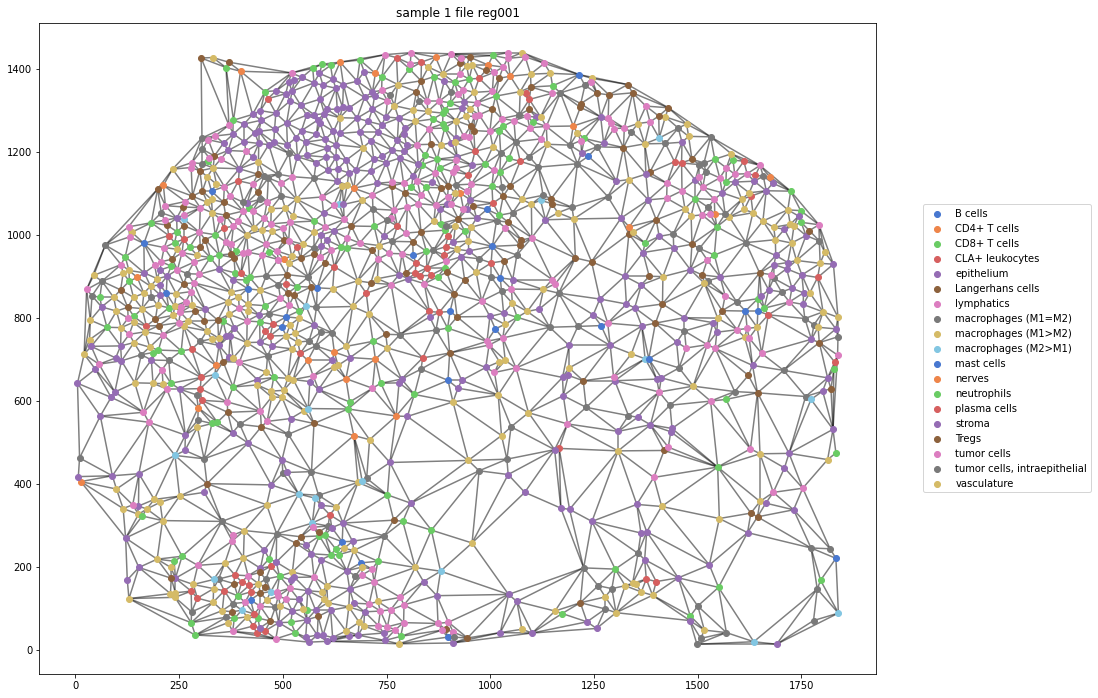

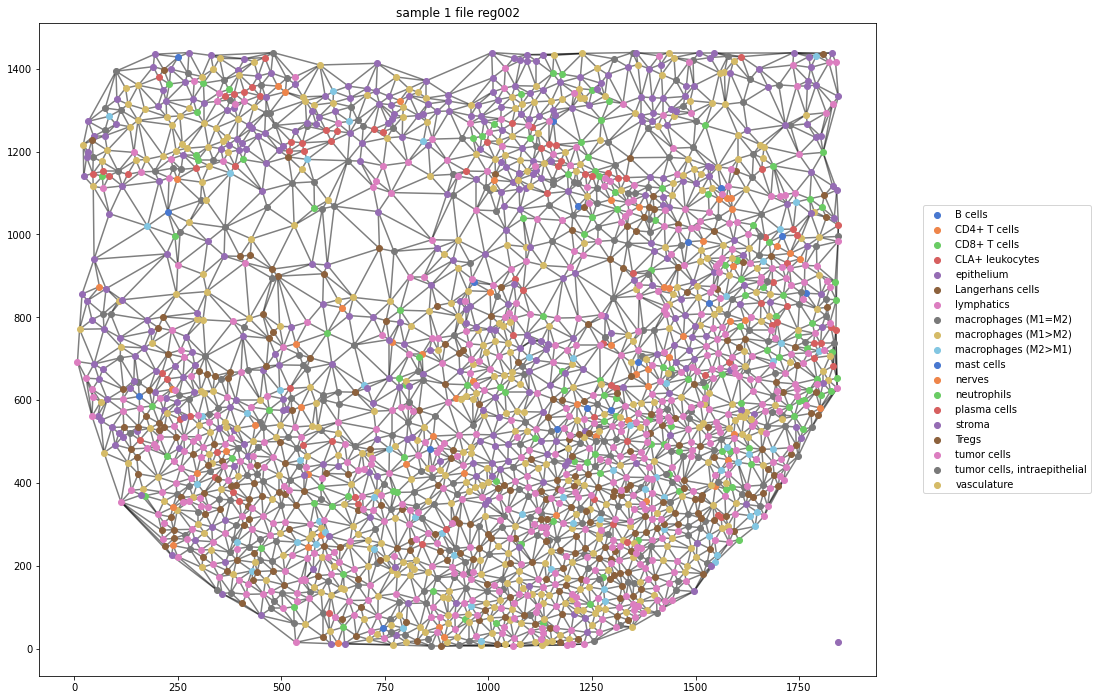

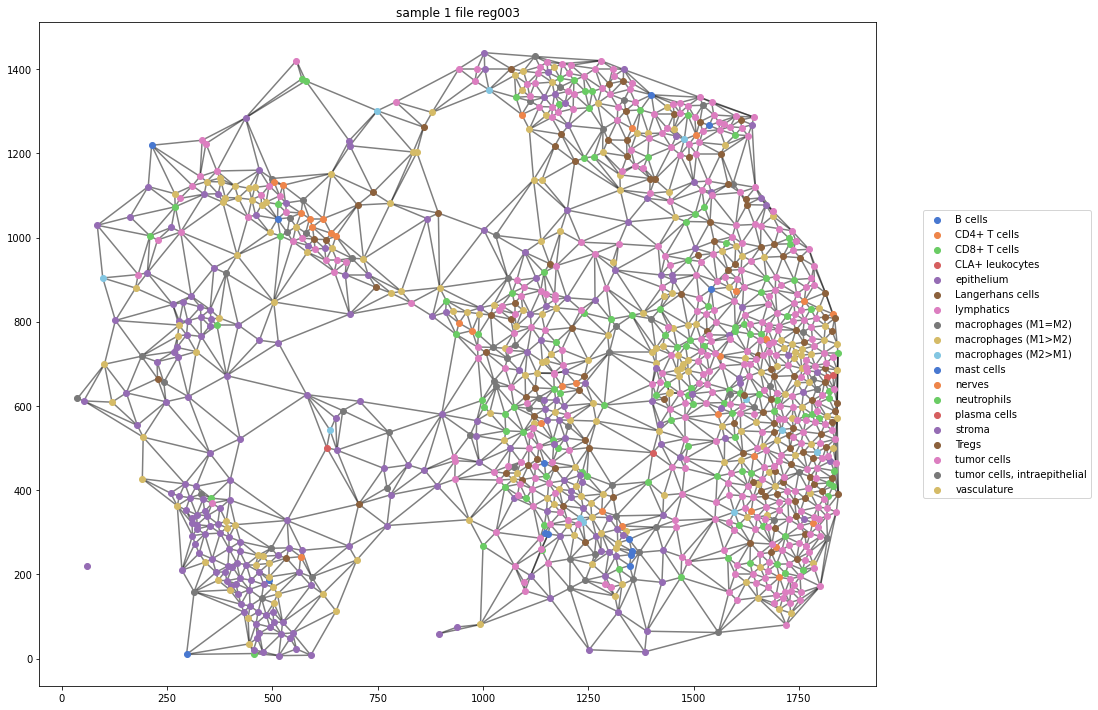

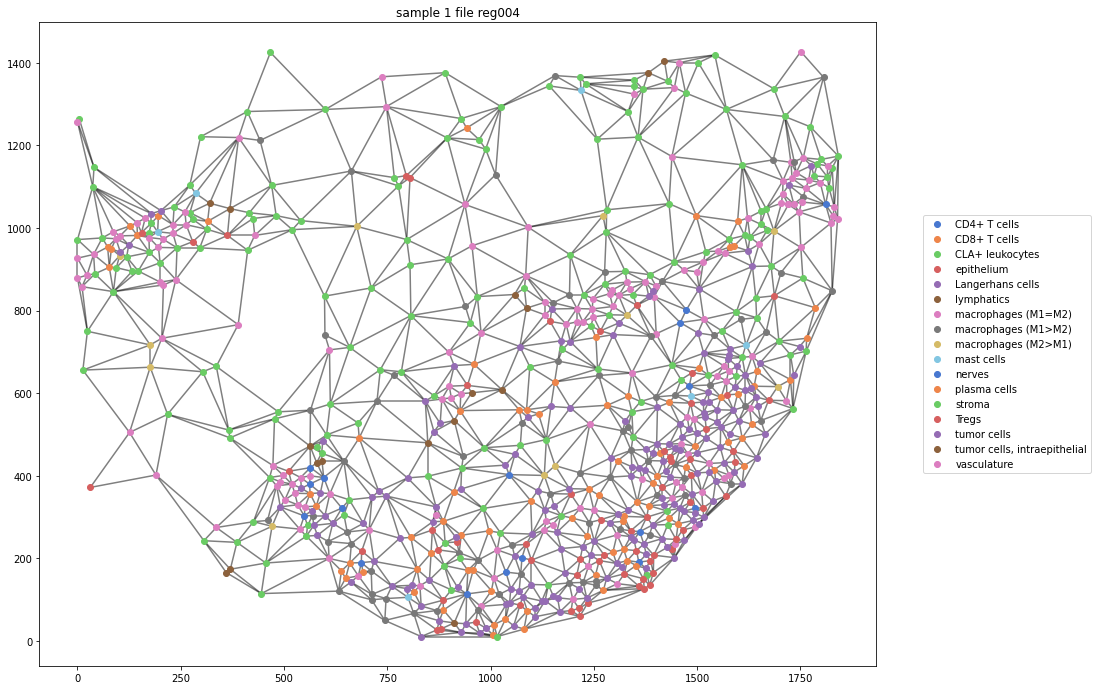

In [11]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[cell_pos_cols].values
    pairs = ty.build_delaunay(coords, trim_dist=200)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    # pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [11]:
processed_dir = Path('../data/processed/CODEX_CTCL')
save_dir = processed_dir / "all_samples_networks_xy_solitary-0_choose_distance"

In [12]:
# Choose optimal distances

files_dst = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

k_sol = 0 

if RUN_LONG:
    for filename in files_dst:
        print("    processing filename {}".format(filename))
        select_file = obj['FileName'] == filename
        nodes = obj.loc[select_file, all_cols]
        coords = nodes[cell_pos_cols].values
        pairs = ty.build_delaunay(coords, trim_dist=200)
        print("    ", end="")
        if k_sol > 0:
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes['ClusterName'],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_filename-{filename}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [13]:
trim_dist = 'percentile_size' # or 200
k_sol = 0 # or 1, 2, 3, ...
reconst_dir = processed_dir / f"all_samples_networks_xy_trim_dist-{trim_dist}_solitary-{k_sol}"
save_dir = reconst_dir / "networks_images"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [14]:
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [15]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(reconst_dir / 'sample_all-edges.csv', index=False)
else:
    edges_all = pd.read_csv(reconst_dir / 'sample_all-edges.csv')

In [16]:
# or save in separate file for convenience
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_csv(reconst_dir / f'edges_sample-{filename}.csv', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [17]:
# we add attributes to nodes to color network figures
nodes_all = obj[cell_pos_cols].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [18]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
         3             3            23           191                7   
2        1             6             3             5                3   
         3            79            29            18                0   
3        2             2           208           186               14   
         4             0            63           192                8   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
         3                 0                   0                15    160   
2        1                 0                   0                12     15   
         3                 0                   0                13     76   
3        2                 0                   2               130     99   
         4                 0                   8                63    157   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
         3               72          30  ...                  201   
2        1                6           5  ...                   71   
         3              259           0  ...                  265   
3        2             1759          24  ...                  397   
         4             2299           0  ...                  295   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
         3                        22          17      24            2   
2        1                        64           3       6            1   
         3                       146          11      12            0   
3        2                        39          33      17            0   
         4                        43           8       6            0   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
         3                  4     317          527   
2        1                  4     203          155   
         3                 12     396         2900   
3        2                  4     328          546   
         4                  1     278          428   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
         3                                  3          143  
2        1                                  2           95  
         3                                  0          166  
3        2                                274           86  
         4                                320          111  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [19]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2   

#### Descriptive statistics

In [20]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                                      
macrophages (M1=M2)           0.212121   0.999961
CD4+ T cells                  0.212121   0.999961
tumor cells                   0.575175   0.999961
macrophages (M2>M1)           0.575175   0.999961
lymphatics                    0.575175   0.999961
Langerhans cells              0.575175   0.999961
B cells                       0.575175   0.999961
CD8+ T cells                  0.575175   0.999961
IDO+ stromal cells            0.575175   0.999961
vasculature                   0.575175   0.999961
Tregs                         0.962704   0.999961
epithelium                    0.962704   0.999961
tumor cells, intraepithelial  0.962704   0.999961
macrophages (M1>M2)           0.962704   0.999961
CLA+ leukocytes               0.962704   0.999961
nerves                        0.962704   0.999961
neutrophils                   0.962704   0.999961
stroma                        0.962704   0.999961
DCs, CD11c+                   0.999961   0.999961
mast cells                    0.999961   0.999961
plasma cells                  0.999961   0.999961

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [21]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [22]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / stroma) / (stroma / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((macrophages (M1=M2) / macrophages (M1>M2)) / ...  0.008159        1.0
((B cells / macrophages (M2>M1)) / (nerves / tu...  0.008159        1.0
((lymphatics / stroma) / (nerves / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (mast cel...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M2>M1) /...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1>M2) /...  0.008159        1.0
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

In [23]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2          0.000000   

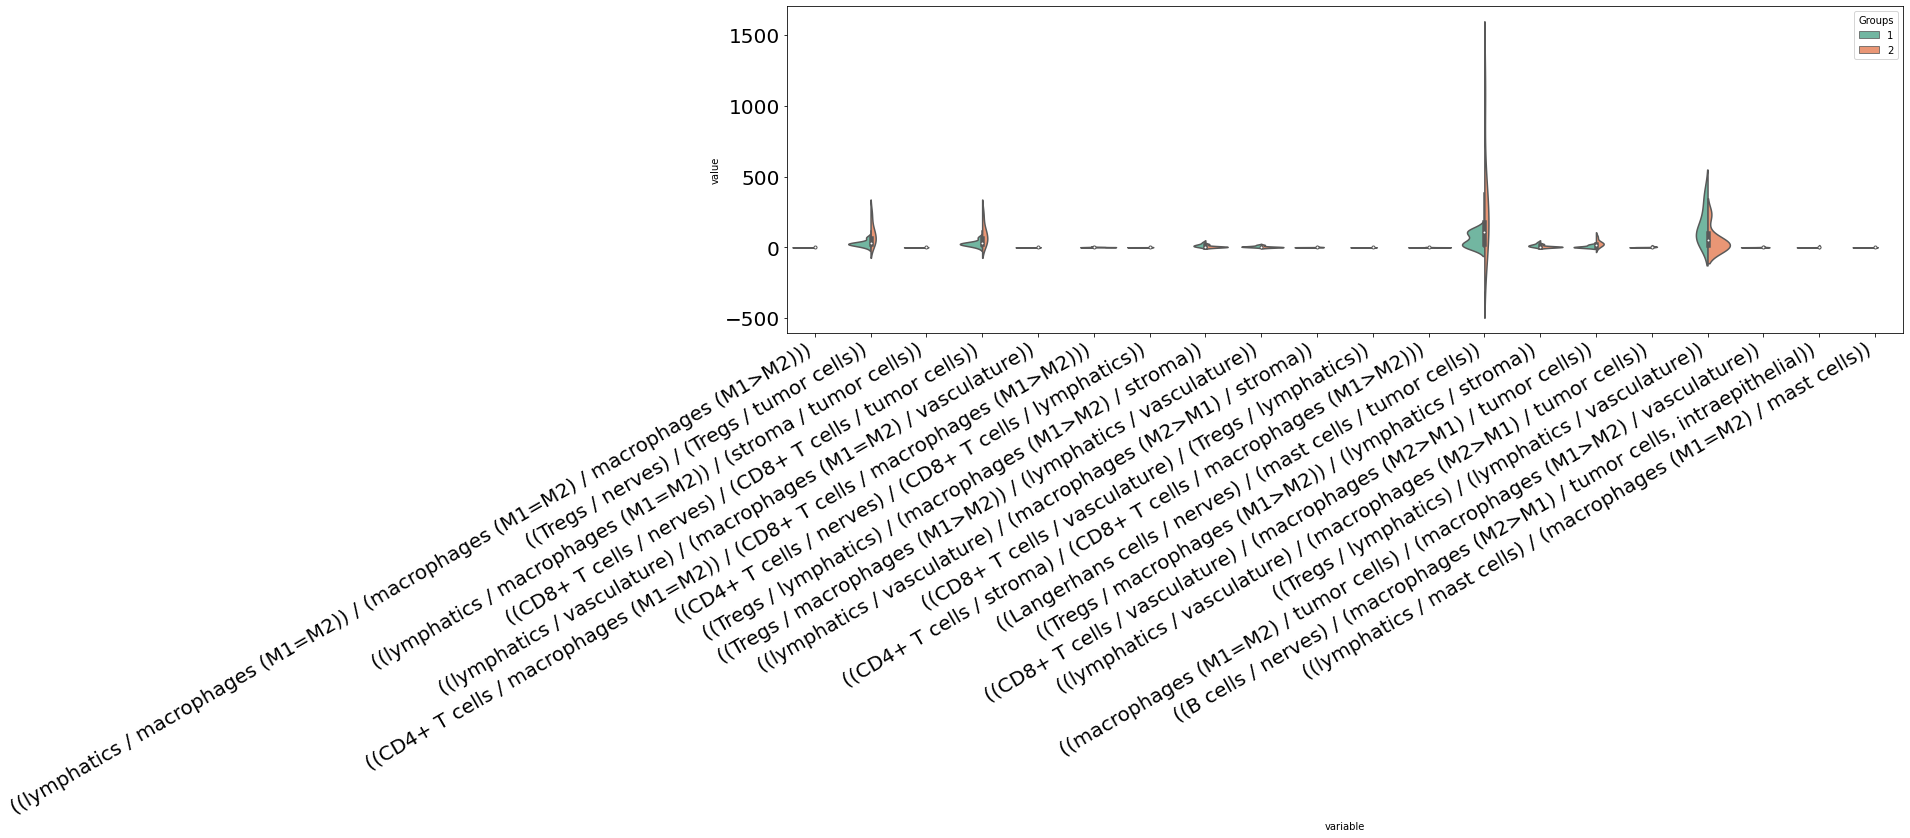

In [24]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

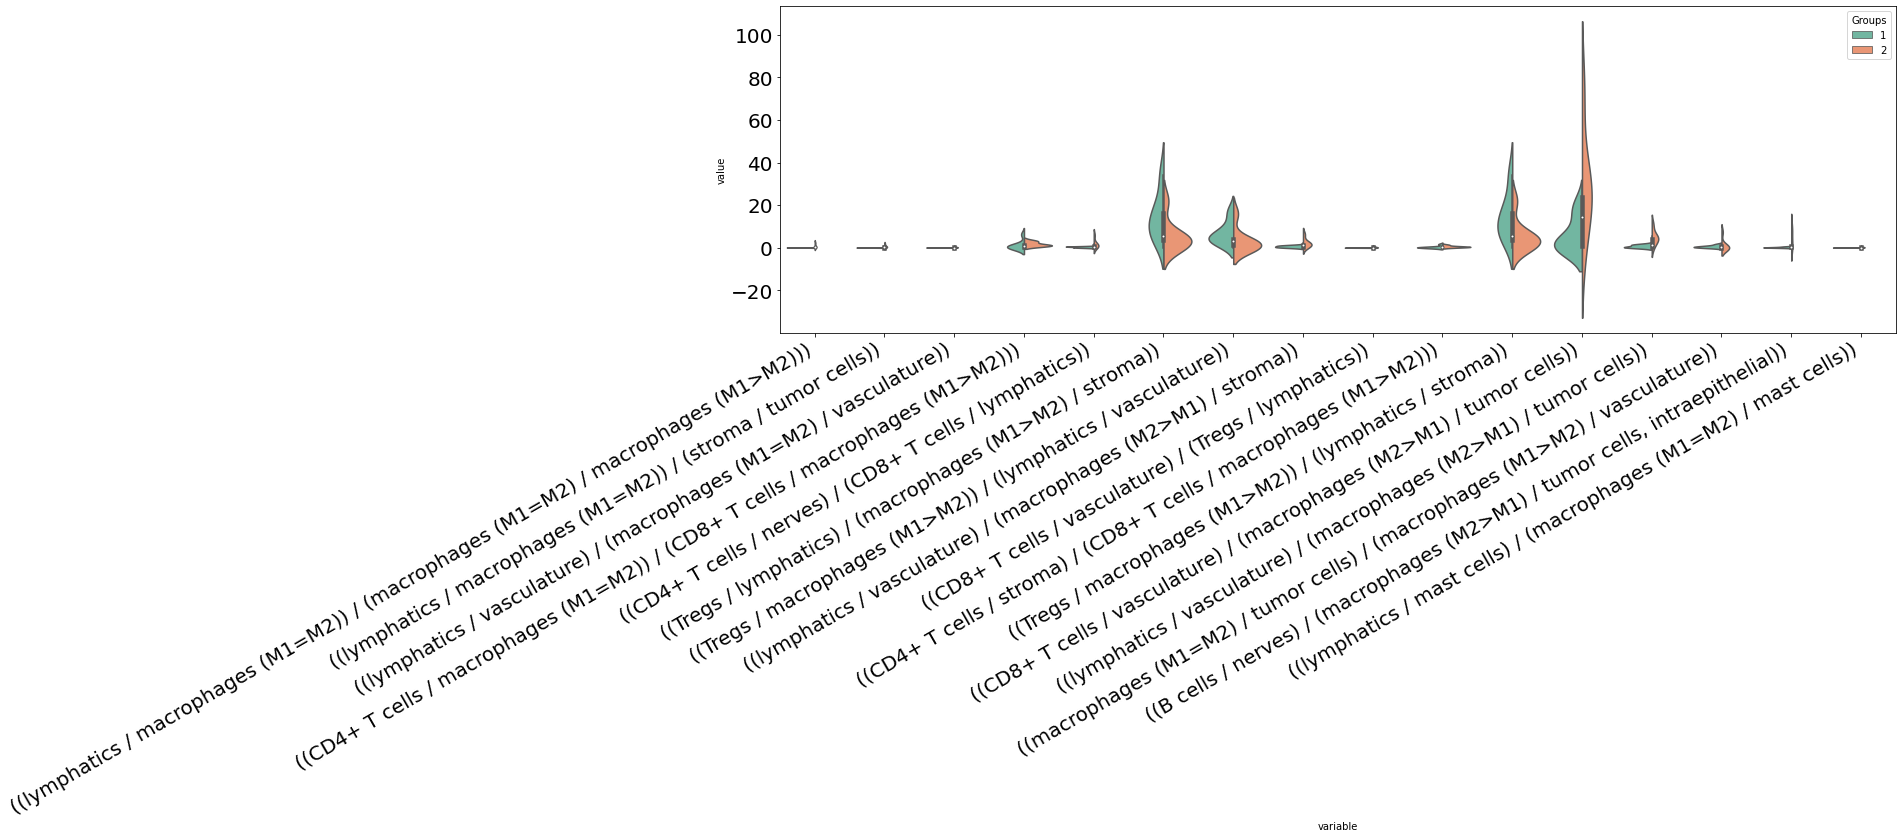

In [25]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

Here we standardize the columns to amake them moe comparable between each other and get a more relevant bi-clustering.

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


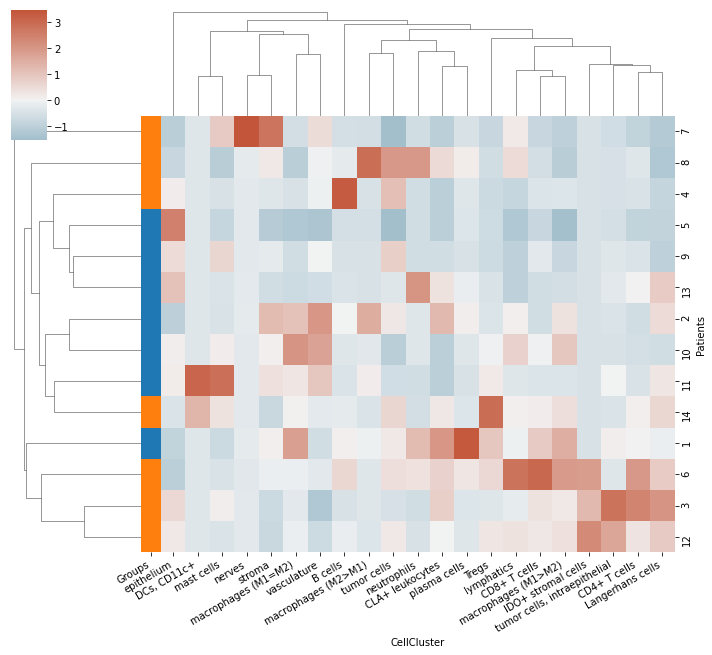

In [26]:
g = mosna.plot_heatmap(
    prop_types.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    )

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [25]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 131834 non finite values
Imputing data


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


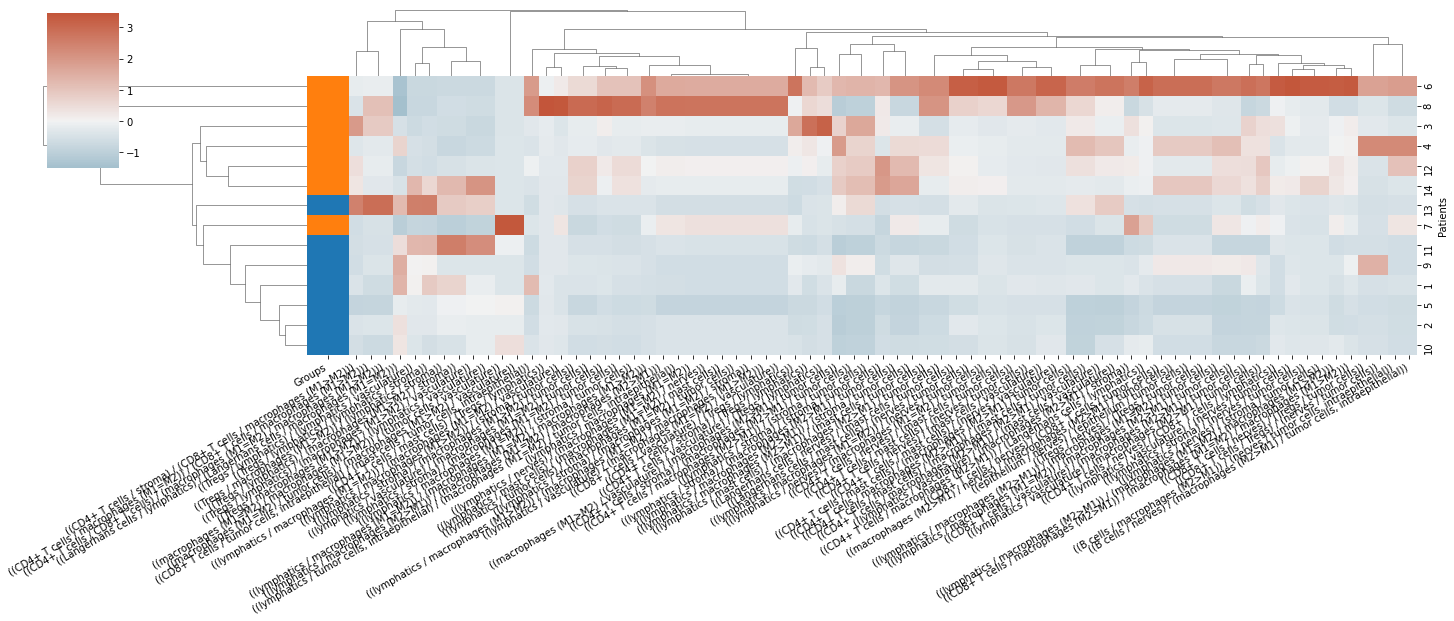

In [26]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.  
We must be careful though: we have computed a lot of composed variables, and selected those who happened to have the best p-values.

#### Stepwise logistic regression

In [27]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.00186317
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.000234876
Add  ((CD8+ T cells / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 0.00216709


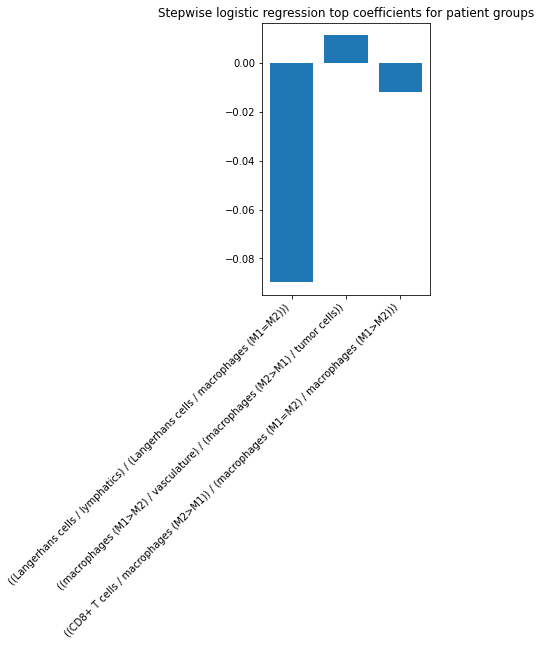

In [28]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [29]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [28]:
grouping = 'FileName'
n_shuffle = 500
load_dir = reconst_dir
save_dir = load_dir / "assortativity"
filename = save_dir / f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'

if RUN_LONG or not filename.exists():
    start = time()
    net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                    attributes=attribute_uniq, 
                                    groups=obj[grouping], 
                                    n_shuffle=n_shuffle,
                                    parallel_groups=False,
                                    memory_limit='100GB',
                                    save_intermediate_results=False, 
                                    dir_save_interm=save_dir)
    end = time()
    duration = end - start
    print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(filename)
else:
    print("Loading assortativity results")
    net_stats = pd.read_csv(filename, index_col=0)

Loading assortativity results


In [29]:
net_stats

# total  % B cells  % CD4+ T cells  % CD8+ T cells  % CLA+ leukocytes  \
id                                                                              
reg001     1301   0.017679        0.012298        0.082244           0.009224   
reg002     2324   0.004733        0.014630        0.052496           0.003442   
reg006      603   0.009950        0.004975        0.008292           0.004975   
reg035     2053   0.000487        0.007306        0.014613           0.000974   
reg036      618   0.001618        0.006472        0.033981           0.000000   
...         ...        ...             ...             ...                ...   
reg005      112   0.000000        0.000000        0.000000           0.000000   
reg018      458   0.000000        0.000000        0.000000           0.000000   
reg027      249   0.000000        0.004016        0.000000           0.000000   
reg026      257   0.000000        0.000000        0.000000           0.000000   
reg025      144   0.000000        0.000000        0.000000           0.000000   

        % DCs, CD11c+  % epithelium  % IDO+ stromal cells  % Langerhans cells  \
id                                                                              
reg001            0.0      0.069178                   0.0            0.016910   
reg002            0.0      0.009466                   0.0            0.008606   
reg006            0.0      0.006633                   0.0            0.019900   
reg035            0.0      0.500731                   0.0            0.004384   
reg036            0.0      0.021036                   0.0            0.003236   
...               ...           ...                   ...                 ...   
reg005            0.0      0.017857                   0.0            0.000000   
reg018            0.0      0.884279                   0.0            0.004367   
reg027            0.0      0.088353                   0.0            0.000000   
reg026            0.0      0.000000                   0.0            0.003891   
reg025            0.0      0.000000                   0.0            0.000000   

        % lymphatics  ...  vasculature - macrophages (M2>M1) Z  \
id                    ...                                        
reg001      0.011530  ...                            -1.180905   
reg002      0.003442  ...                            -1.690702   
reg006      0.008292  ...                            -1.764769   
reg035      0.000000  ...                            -0.813614   
reg036      0.006472  ...                            -1.306752   
...              ...  ...                                  ...   
reg005      0.000000  ...                            -1.128904   
reg018      0.000000  ...                                  NaN   
reg027      0.056225  ...                            -0.379071   
reg026      0.011673  ...                                  NaN   
reg025      0.000000  ...                                  NaN   

        vasculature - mast cells Z  vasculature - nerves Z  \
id                                                           
reg001                   -0.390567               -0.718191   
reg002                   -0.543771               -1.060329   
reg006                   -0.300005               -0.524334   
reg035                   -1.517397               -0.504822   
reg036                   -1.657617               -1.443627   
...                            ...                     ...   
reg005                   -0.452257                     NaN   
reg018                   -0.214535               -0.260777   
reg027                   -0.799200               -0.766669   
reg026                   -0.925010               -4.166897   
reg025                         NaN               -1.313479   

        vasculature - neutrophils Z  vasculature - plasma cells Z  \
id                                                                  
reg001                    -1.276432                     -1.872294   
reg002                    -

#### Example of Mixing Matrix

In [30]:
sample_id = 'reg001'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Raw assortativity by cell types: 1.00
Z-scored assortativity by cell types: 85.99


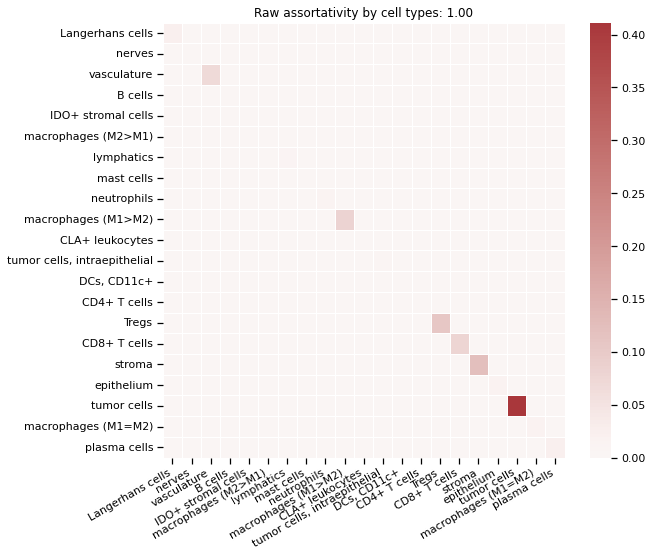

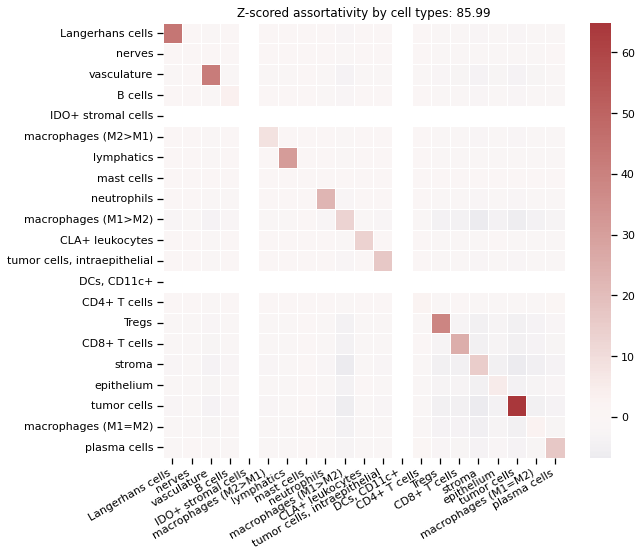

In [31]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

Raw assortativity by cell types: 1.00
Z-scored assortativity by cell types: 85.99


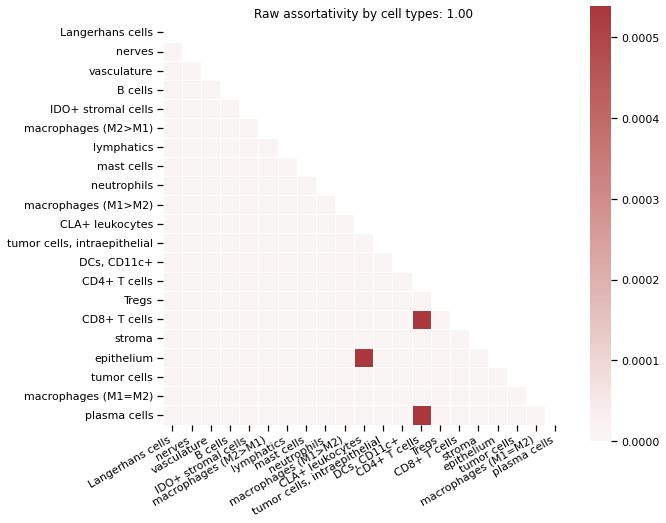

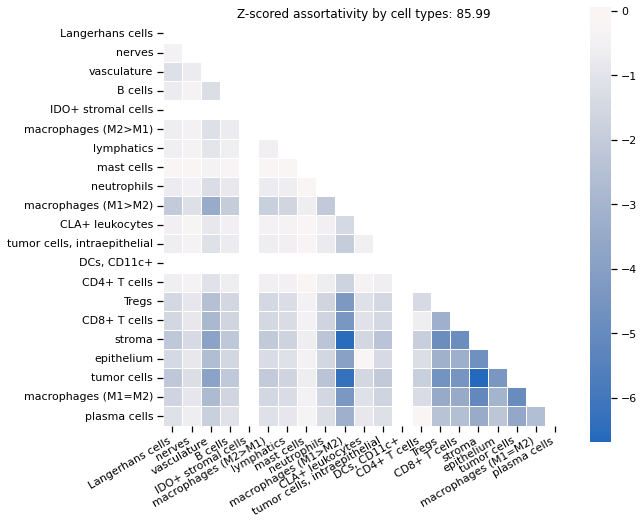

In [32]:
# Hide diagonal
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

After removing highly self-assortative cell-types, we can notice that most cell types tend to avoid other cell types in this sample.

#### Assortativity and patients response

In [33]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols]

In [34]:
z_net_stats

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
id                                                                  
reg001   85.985427             3.395582                 -0.660735   
reg002  103.903917            -0.169725                 -0.405964   
reg006   34.335030            -0.089803                 -0.119159   
reg035   98.395251                  NaN                 -0.135388   
reg036   52.615083                  NaN                 -0.127515   
...            ...                  ...                       ...   
reg005    9.140362                  NaN                       NaN   
reg018   40.855482                  NaN                       NaN   
reg027   28.615036                  NaN                       NaN   
reg026   23.670924                  NaN                       NaN   
reg025   12.344420                  NaN                       NaN   

        CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
id                                                                
reg001                       2.314119                 -1.607368   
reg002                      13.296833                 -0.854290   
reg006                      -0.077693                 -0.198749   
reg035                      20.966968                 -0.194257   
reg036                      -0.110208                 -0.257600   
...                               ...                       ...   
reg005                            NaN                       NaN   
reg018                            NaN                       NaN   
reg027                            NaN                       NaN   
reg026                            NaN                       NaN   
reg025                            NaN                       NaN   

        CD8+ T cells - CD4+ T cells Z  CD8+ T cells - CD8+ T cells Z  \
id                                                                     
reg001                      -0.642771                      25.100633   
reg002                       1.875091                      21.125516   
reg006                      -0.142857                      -0.127515   
reg035                      -0.815247                      14.913447   
reg036                      -0.531380                       4.968835   
...                               ...                            ...   
reg005                            NaN                            NaN   
reg018                            NaN                            NaN   
reg027                            NaN                            NaN   
reg026                            NaN                            NaN   
reg025                            NaN                            NaN   

        CLA+ leukocytes - B cells Z  CLA+ leukocytes - CD4+ T cells Z  \
id                                                                      
reg001                    -0.532509                         -0.394176   
reg002                    -0.220326                         -0.402645   
reg006                    -0.135388                         -0.077693   
reg035                          NaN                         -0.219586   
reg036                          NaN                               NaN   
...                             ...                               ...   
reg005                          NaN                               NaN   
reg018                          NaN                               NaN   
reg027                          NaN                               NaN   
reg026                          NaN                               NaN   
reg025                          NaN                               NaN   

        CLA+ leukocytes - CD8+ T cells Z  ...  \
id                                        ...   
reg001                         -1.073309  ...   
reg002                         -0.649189  ...   
reg006                         -0.149983  ...   
reg035                         -0.301561  ...   
reg036                               NaN  ...   
...       

In [35]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   23
CD4+ T cells - B cells Z                              16
CD4+ T cells - CD4+ T cells Z                         10
CD8+ T cells - B cells Z                              15
CD8+ T cells - CD4+ T cells Z                         7
CD8+ T cells - CD8+ T cells Z                         8
CLA+ leukocytes - B cells Z                           31
CLA+ leukocytes - CD4+ T cells Z                      23
CLA+ leukocytes - CD8+ T cells Z                      23
CLA+ leukocytes - CLA+ leukocytes Z                   34
DCs, CD11c+ - B cells Z                               54
DCs, CD11c+ - CD4+ T cells Z                          53
DCs, CD11c+ - CD8+ T cells Z                          53
DCs, CD11c+ - CLA+ leukocytes Z                       59
DCs, CD11c+ - DCs, CD11c+ Z                           60
epithelium - B cells Z                                15
epithelium - CD4+ T cells Z       

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [36]:
# we need to clean-up data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.9,
    )

There are 4655 non finite values
Imputing data


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1373: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, :]

Let's add information about patients' group and time of biopsy

In [37]:
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

In [38]:
# samples 25, 36, 37, 40, 44 are missing
# pd.set_option('display.max_rows', 10)
# reg026 and reg044 not in biopsies
z_net_stats_cleaned = pd.concat([status, z_net_stats_cleaned], axis=1, join='inner').sort_values('Spots')
z_net_stats_cleaned.drop(columns=['Spots'], inplace=True)
z_net_stats_cleaned

Patients  Groups    assort Z  B cells - B cells Z  \
id                                                          
reg001         1       1   85.985427             3.395582   
reg002         1       1  103.903917            -0.169725   
reg003         1       3   80.646093            -0.077693   
reg004         1       3   54.784417             7.789058   
reg006         2       1   34.335030            -0.089803   
...          ...     ...         ...                  ...   
reg066        14       4   58.411768             4.089673   
reg067         9       3  160.180767            21.476127   
reg068         9       3  126.913150            11.202822   
reg069        13       3   89.854771            22.665858   
reg070        13       3   44.032249             0.610905   

        CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -0.660735                       2.314119   
reg002                 -0.405964                      13.296833   
reg003                 -0.284154                      12.542358   
reg004                 -0.534668                       3.646853   
reg006                 -0.119159                      -0.077693   
...                          ...                            ...   
reg066                 -0.044766                       9.048780   
reg067                 -2.767451                      15.859577   
reg068                 -1.216186                      11.591721   
reg069                 -0.779909                      -0.149983   
reg070                 -0.123436                      -0.063372   

        CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
id                                                                
reg001                 -1.607368                      -0.642771   
reg002                 -0.854290                       1.875091   
reg003                 -0.703670                      -1.528229   
reg004                 -0.827886                      -1.026222   
reg006                 -0.198749                      -0.142857   
...                          ...                            ...   
reg066                 -0.156813                      -0.225245   
reg067                 -2.986499                      -8.512845   
reg068                 -2.150948                      -5.516324   
reg069                 -1.404669                      -0.715866   
reg070                 -0.258509                      -0.142857   

        CD8+ T cells - CD8+ T cells Z  CLA+ leukocytes - B cells Z  ...  \
id                                                                  ...   
reg001                      25.100633                    -0.532509  ...   
reg002                      21.125516                    -0.220326  ...   
reg003                      12.303937                    -0.100504  ...   
reg004                      11.062860                    -0.155689  ...   
reg006                      -0.127515                    -0.135388  ...   
...                               ...                          ...  ...   
reg066                      15.554503                    -0.063372  ...   
reg067                      42.282358                    -0.289725  ...   
reg068                      40.439002                    -0.188693  ...   
reg069                      40.157212                    -0.347048  ...   
reg070                       4.783082                    -0.155408  ...   

        vasculature - macrophages (M2>M1) Z  vasculature - mast cells Z  \
id                                                                        
reg001                            -1.180905                   -0.390567   
reg002                            -1.690702                   -0.543771   
reg003                            -1.106285                   -1.101415   
reg004                            -1.073891                   -0.773542   
reg006                            -1.764769 

In [39]:
pvals = mosna.find_DE_markers(z_net_stats_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [40]:
pvals.head(20)

pval  pval_corr
tumor cells - B cells Z                             0.003885   0.323676
mast cells - B cells Z                              0.003885   0.323676
tumor cells - lymphatics Z                          0.005581   0.323676
Langerhans cells - B cells Z                        0.005581   0.323676
CD4+ T cells - B cells Z                            0.007907   0.366868
DCs, CD11c+ - DCs, CD11c+ Z                         0.012482   0.404514
tumor cells - CD4+ T cells Z                        0.015692   0.404514
mast cells - mast cells Z                           0.015692   0.404514
IDO+ stromal cells - CLA+ leukocytes Z              0.015692   0.404514
tumor cells - macrophages (M1>M2) Z                 0.019914   0.451787
macrophages (M1>M2) - B cells Z                     0.025718   0.451787
vasculature - CD4+ T cells Z                        0.025718   0.451787
nerves - CD4+ T cells Z                             0.025718   0.451787
macrophages (M2>M1) - B cells Z                     0.032351   0.451787
tumor cells - CD8+ T cells Z                        0.032351   0.451787
CD8+ T cells - B cells Z                            0.032351   0.451787
Tregs - DCs, CD11c+ Z                               0.038947   0.451787
stroma - lymphatics Z                               0.038947   0.451787
tumor cells - stroma Z                              0.038947   0.451787
tumor cells, intraepithelial - IDO+ stromal cel...  0.038947   0.451787

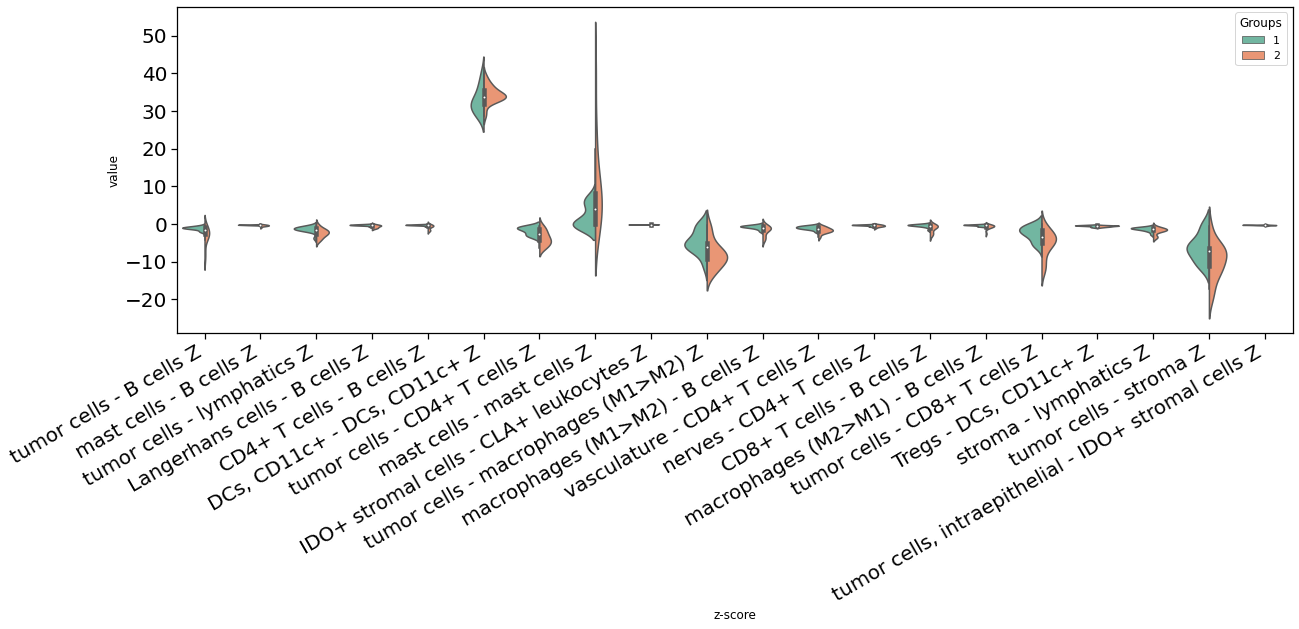

In [41]:
reload(mosna)
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

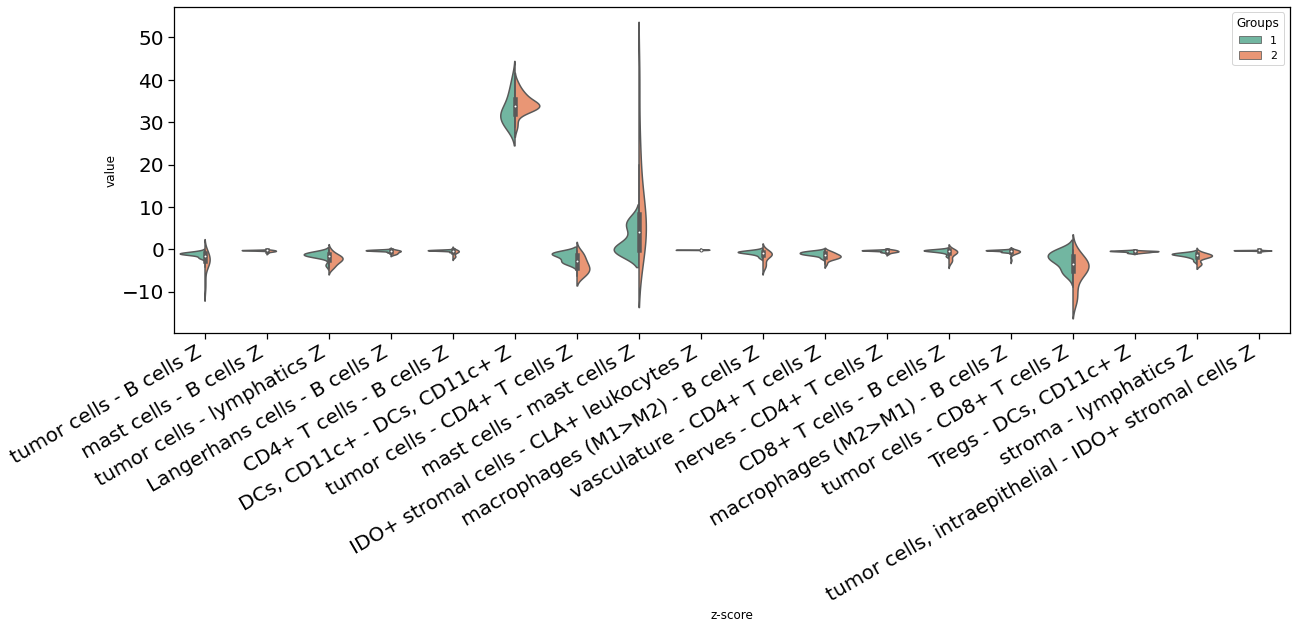

In [42]:
exclude_vars = [
    'assort Z',
    'neutrophils - neutrophils Z',
    'tumor cells - stroma Z',
    'tumor cells - macrophages (M1>M2) Z',
]
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    exclude_vars=exclude_vars,
    )

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


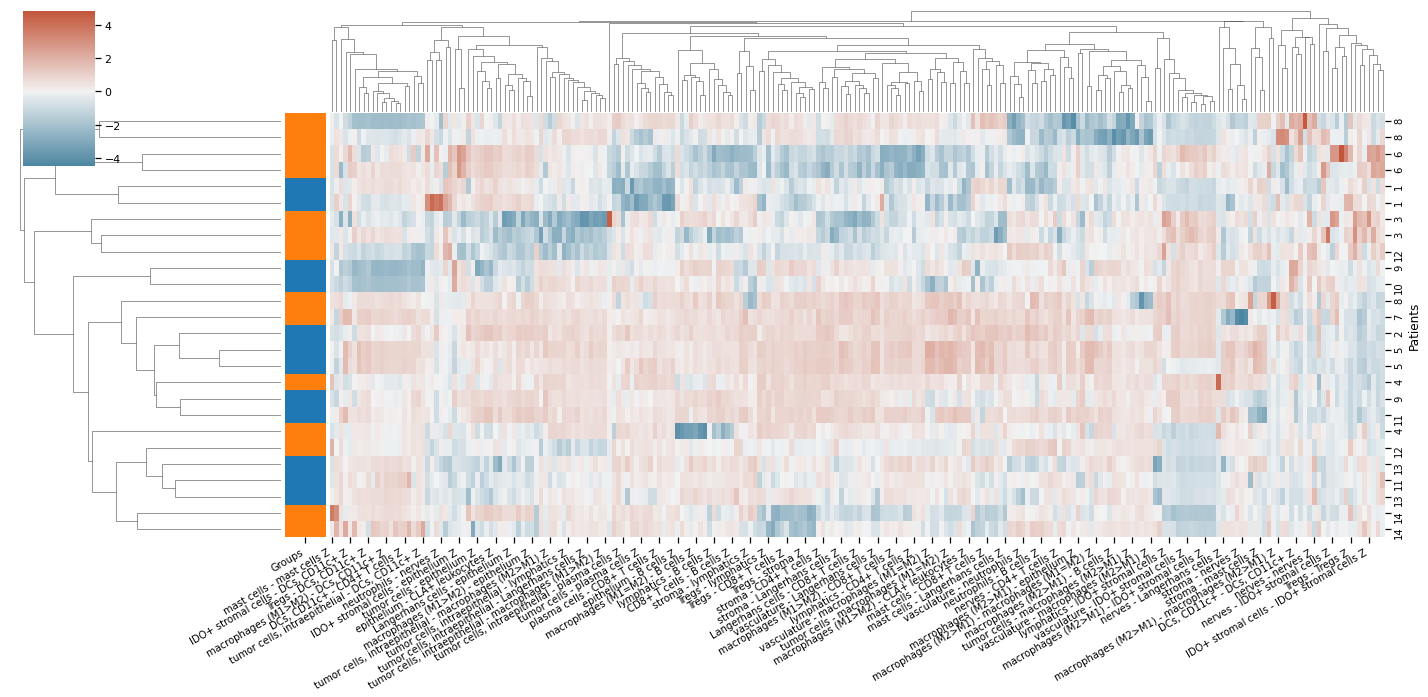

In [43]:
mosna.plot_heatmap(
    z_net_stats_cleaned, 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    skip_cols=['assort Z'],
    )

Samples are a bit clustered into consistent response groups, but it's not incredible.  
We also need to aggregate samples per patient and time of biopsy, that may help us correcting nan values and have more variables, and hopefully better clusters.

#### Samples aggregation per patient and time point.

In [44]:
z_net_stats = pd.concat([status, z_net_stats], axis=1, join='inner').sort_values('Spots')
z_net_stats.drop(columns=['Spots'], inplace=True)

In [45]:
# good news: the mean of aggregated data already ignores nans
z_net_stats_agg = z_net_stats.groupby(['Patients', 'Groups']).mean()
z_net_stats_agg

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
Patients Groups                                                              
1        1        94.944672             1.612929                 -0.533350   
         3        67.715255            -0.077693                 -0.284154   
2        1        34.335030            -0.089803                 -0.119159   
         3       112.196741             9.654737                 -0.754458   
3        2       127.415623            -0.044766                 -0.527614   
         4       124.386652                  NaN                       NaN   
4        2        74.027075            58.381229                 -1.032297   
         4       103.371494            13.010042                 -0.457199   
5        1        43.044394                  NaN                       NaN   
         3        37.458638                  NaN                 -0.063372   
6        2       115.319723             9.492851                 -1.699844   
         4       129.421182            20.665786                  1.116470   
7        2        23.670924                  NaN                       NaN   
         4        36.469171            -0.119159                 -0.127515   
8        2        90.400617            -0.253166                 -0.386591   
         4       122.608791            17.405901                  0.049887   
9        1        75.505167                  NaN                 -0.131452   
         3       108.908432            10.867085                 -1.415622   
10       1        99.628183            -0.142857                 -0.287183   
         3        96.253333            -0.077693                 -0.142857   
11       1        54.151229            -0.044766                       NaN   
         3        31.521022            -0.063372                 -0.063372   
12       2        97.222346            -0.218834                 -0.588215   
         4       101.134125            -0.175863                  0.474367   
13       1        91.827906            -0.061230                 -0.292155   
         3        84.137972            20.483440                 -1.971075   
14       2        98.972100             1.787380                 -0.534749   
         4       118.091156            14.741237                  3.034202   

                 CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
Patients Groups                                                            
1        1                            7.805476                 -1.230829   
         3                            8.094605                 -0.703670   
2        1                           -0.077693                 -0.198749   
         3                            2.882476                 -0.656042   
3        2                           22.736425                 -0.523826   
         4                           13.888168                       NaN   
4        2                            7.636251                 -1.430839   
         4                           14.144536                 -1.051470   
5        1                                 NaN                       NaN   
         3                            9.050436                 -0.044766   
6        2                           41.434048                 -2.925612   
         4                           23.598693                 -1.920082   
7        2                                 NaN                       NaN   
         4                                 NaN                 -0.403887   
8        2                            4.942658                 -0.367833   
         4                           10.640715                 -1.704238   
9        1                           10.428380                 -0.225929   
         3                            6.685801                 -1.869283   
10       1                           10.043911                 -0.604165   
         3                            6.667424                 -0.380387   
11    

In [46]:
# Have a look at nan values
for name, value in z_net_stats_agg.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   5
CD4+ T cells - B cells Z                              4
CD4+ T cells - CD4+ T cells Z                         4
CD8+ T cells - B cells Z                              3
CD8+ T cells - CD4+ T cells Z                         2
CD8+ T cells - CD8+ T cells Z                         2
CLA+ leukocytes - B cells Z                           10
CLA+ leukocytes - CD4+ T cells Z                      8
CLA+ leukocytes - CD8+ T cells Z                      8
CLA+ leukocytes - CLA+ leukocytes Z                   12
DCs, CD11c+ - B cells Z                               22
DCs, CD11c+ - CD4+ T cells Z                          21
DCs, CD11c+ - CD8+ T cells Z                          21
DCs, CD11c+ - CLA+ leukocytes Z                       23
DCs, CD11c+ - DCs, CD11c+ Z                           24
epithelium - B cells Z                                3
epithelium - CD4+ T cells Z              

In [47]:
z_net_agg_cleaned, select_finite = mosna.clean_data(
    z_net_stats_agg, 
    method='mixed',
    thresh=0.9,
    )

There are 1516 non finite values
Imputing data


In [48]:
pvals = mosna.find_DE_markers(z_net_agg_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [49]:
pvals.head(20)

pval  pval_corr
tumor cells - lymphatics Z                          0.008159   0.942308
macrophages (M1=M2) - lymphatics Z                  0.053030   0.942308
tumor cells, intraepithelial - IDO+ stromal cel...  0.053030   0.942308
mast cells - mast cells Z                           0.053030   0.942308
tumor cells - CD4+ T cells Z                        0.053030   0.942308
IDO+ stromal cells - B cells Z                      0.053030   0.942308
tumor cells - macrophages (M1>M2) Z                 0.053030   0.942308
CLA+ leukocytes - CD8+ T cells Z                    0.053030   0.942308
IDO+ stromal cells - epithelium Z                   0.053030   0.942308
tumor cells - B cells Z                             0.053030   0.942308
vasculature - B cells Z                             0.212121   0.942308
macrophages (M1=M2) - CLA+ leukocytes Z             0.212121   0.942308
vasculature - CD4+ T cells Z                        0.212121   0.942308
vasculature - vasculature Z                         0.212121   0.942308
macrophages (M1=M2) - IDO+ stromal cells Z          0.212121   0.942308
mast cells - IDO+ stromal cells Z                   0.212121   0.942308
tumor cells - Langerhans cells Z                    0.212121   0.942308
vasculature - tumor cells, intraepithelial Z        0.212121   0.942308
neutrophils - mast cells Z                          0.212121   0.942308
macrophages (M1>M2) - B cells Z                     0.212121   0.942308

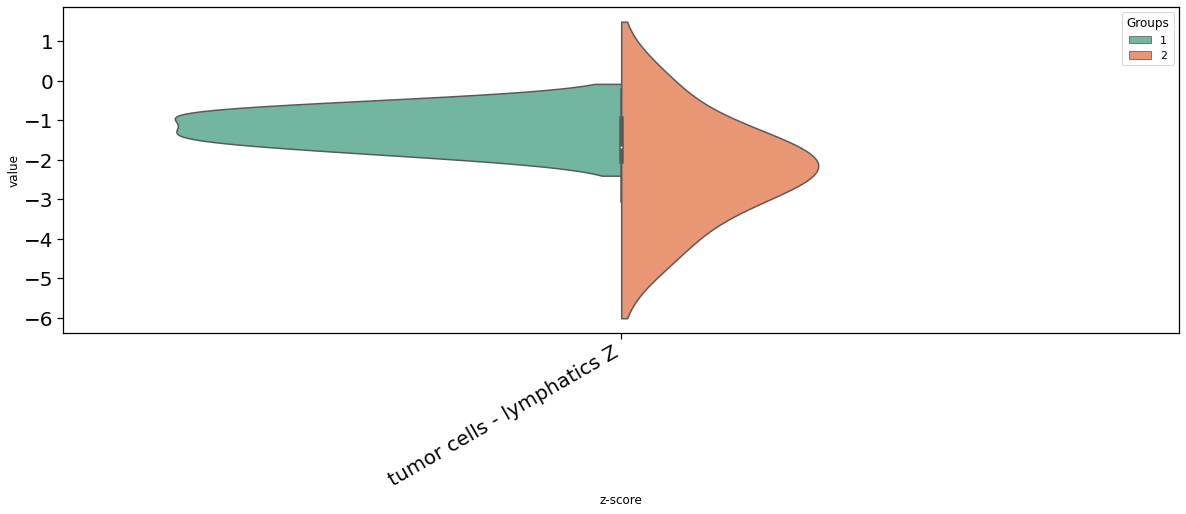

In [50]:
fig, ax = mosna.plot_distrib_groups(
    z_net_agg_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


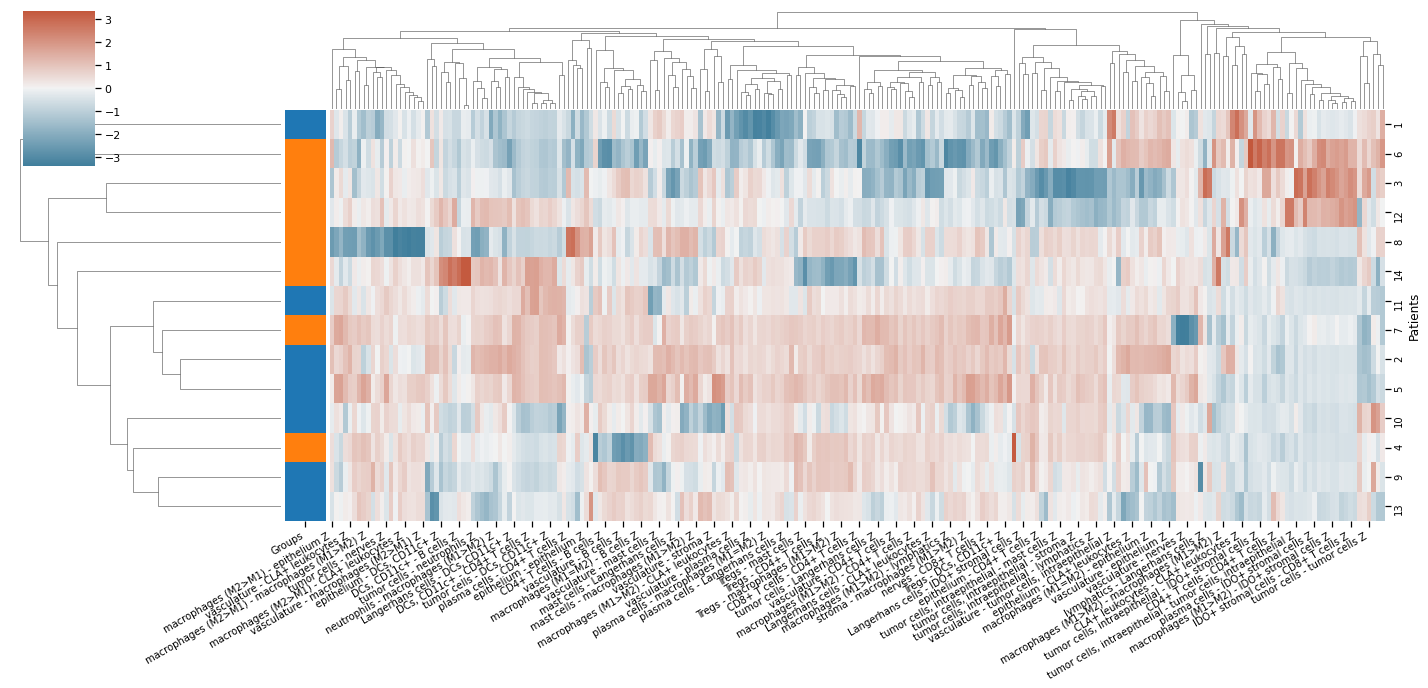

In [51]:
mosna.plot_heatmap(
    z_net_agg_cleaned.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

In [65]:
# # use the most statistically relevant variable separating groups
# # Note: that's to have a clue, do not use this method for real,
# # it's a tautology!

# nb_vars = np.sum(pvals['pval'] <= 0.05)
# nb_vars = min(nb_vars, 20)
# marker_vars = pvals.sort_values(by='pval', ascending=True).head(nb_vars).index.tolist()

# mosna.plot_heatmap(
#     z_net_agg_cleaned[marker_vars].reset_index(), 
#     obs_labels='Patients', 
#     group_var='Groups', 
#     groups=[1, 2],
#     figsize=(10, 10),
#     )

### Marker-positive cells interactions

We can also compute the mixing matrix and assortativity between marker-positive cells.

## Cellular neighborhoods

The mixing matrix and assortativity give us information about the global network organization.  
Here we will see how to use the *Neighbors Aggregation Statistics* method to find local "cellular communities", or "neighborhoods", or "niches", that can be relevant to understand disease progression or response to therapies.  

### First order neighbors, mean and std

In [50]:
order = 1
var_type = 'cell-types'
stat_names = 'mean-std'
aggreg_vars = cell_type_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [51]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

In [52]:
# attrib_all = obj[cell_type_cols]
X = obj[aggreg_vars].values
edges_all = pd.read_csv(reconst_dir/ 'sample_all-edges.csv')
pairs = edges_all.values

In [53]:
filename = nas_dir / f'aggregation_statistics.csv'

if filename.exists():
    var_aggreg = pd.read_csv(filename)
else:
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(filename, index=False)

In [54]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer = umap.UMAP(
    random_state=0,
    n_neighbors=n_neighbors,
    metric=metric,
    min_dist=min_dist,
    # we don't modify the other parameters
    # spread=1.0,
    # set_op_mix_ratio=1.0,
    # local_connectivity=1.0,
    # repulsion_strength=1.0,
    # negative_sample_rate=5,
    # transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
# save reduced coordinates
np.save(nas_dir / (reducer_name + '.npy'), embedding, allow_pickle=False, fix_imports=False)
# save the reducer object
joblib.dump(reducer, nas_dir / (reducer_name + '.pkl'))
embedding.shape

/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(117170, 2)

In [47]:
joblib.dump(reducer, str(nas_dir / (reducer_name + '.pkl')))

['../data/processed/CODEX_CTCL/all_samples_networks_xy_trim_dist-percentile_size_solitary-0/nas_on-cell-types_stats-mean-std_order-1/reducer-umap_nneigh-70_metric-euclidean_min_dist-0.0.pkl']

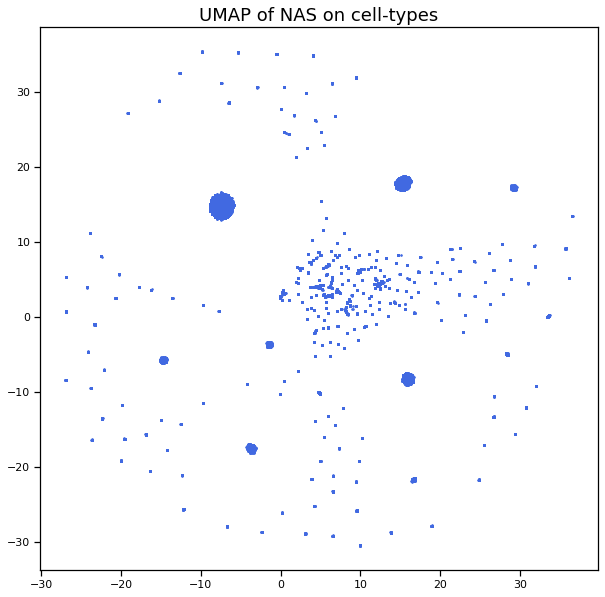

In [48]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Screen NAS parameters

In [ ]:
from importlib import reload
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
parallel_dim = 'max'
parallel_clustering = 4
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'
save_dir = 'test-parallel'

mosna.screen_nas_parameters(X, pairs, markers, orders, dim_clusts, min_cluster_sizes, processed_dir, save_dir=save_dir, soft_clustering=True, 
                            opt_str=opt_str, parallel_dim=parallel_dim, parallel_clustering=parallel_clustering, memory_limit='800GB')


#### Clusters visualization

dim_clust: 2
    min_cluster_size: 100


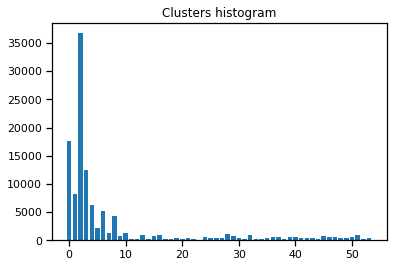

No handles with labels found to put in legend.


        sample: 1


In [188]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.plot_screened_parameters(obj, cell_pos_cols, cell_type_cols, orders, dim_clusts, processed_dir,
                               min_cluster_sizes, all_edges='all_samples_networks', sampling=False, var_type=None, 
                               downsample=False, aggreg_dir=None, load_dir=None, save_dir=None, opt_str=opt_str)

### On markers

In [104]:
order = 1
var_type = 'markers'
stat_names = 'mean-std'
aggreg_vars = marker_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [105]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

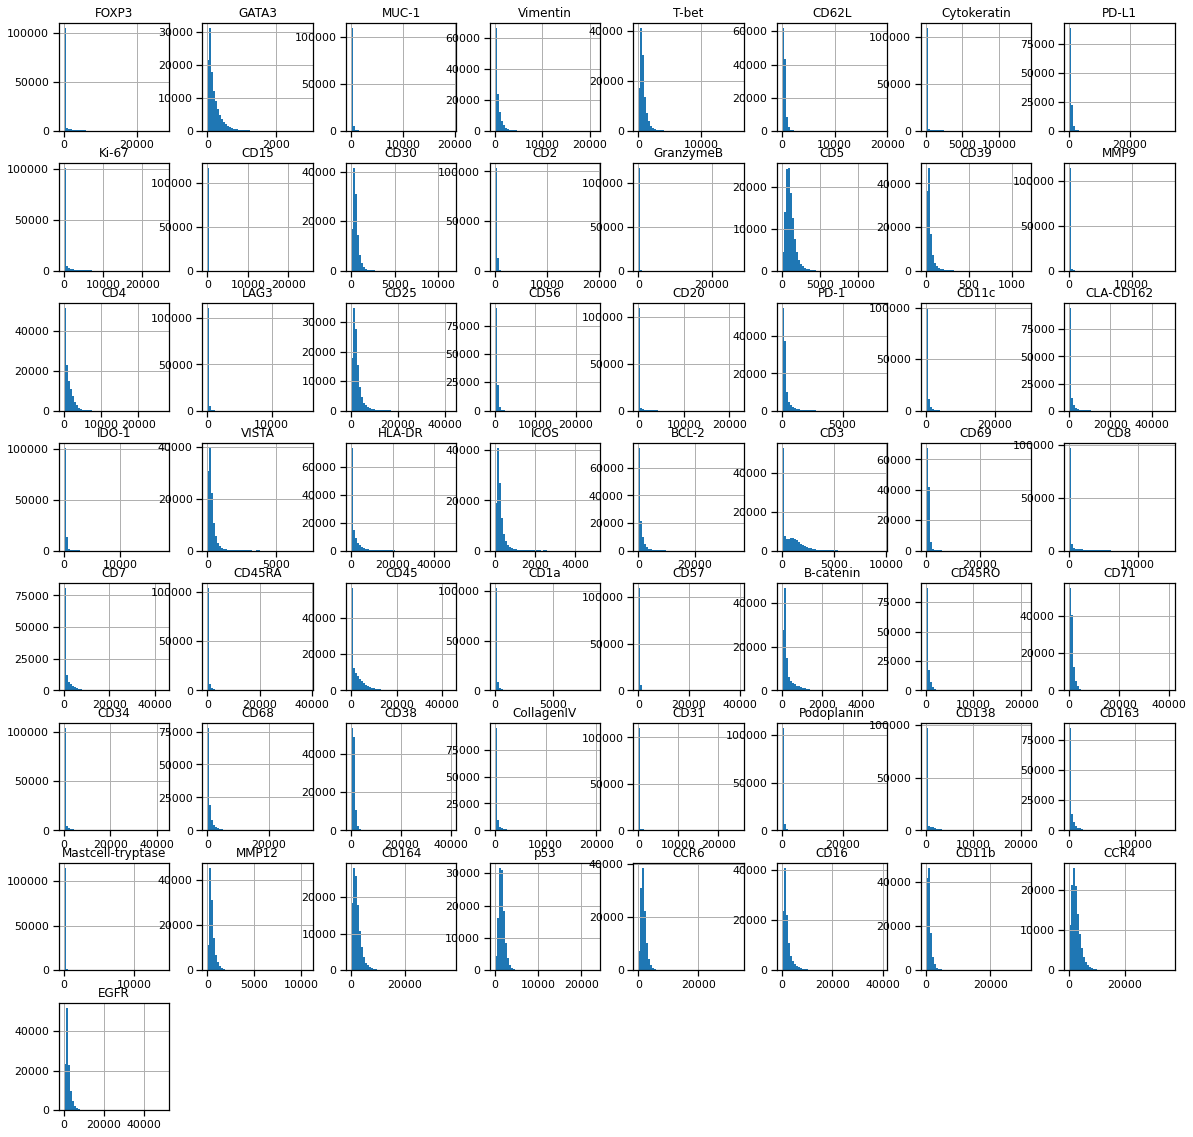

In [106]:
obj[aggreg_vars].hist(bins=50, figsize=(20, 20));

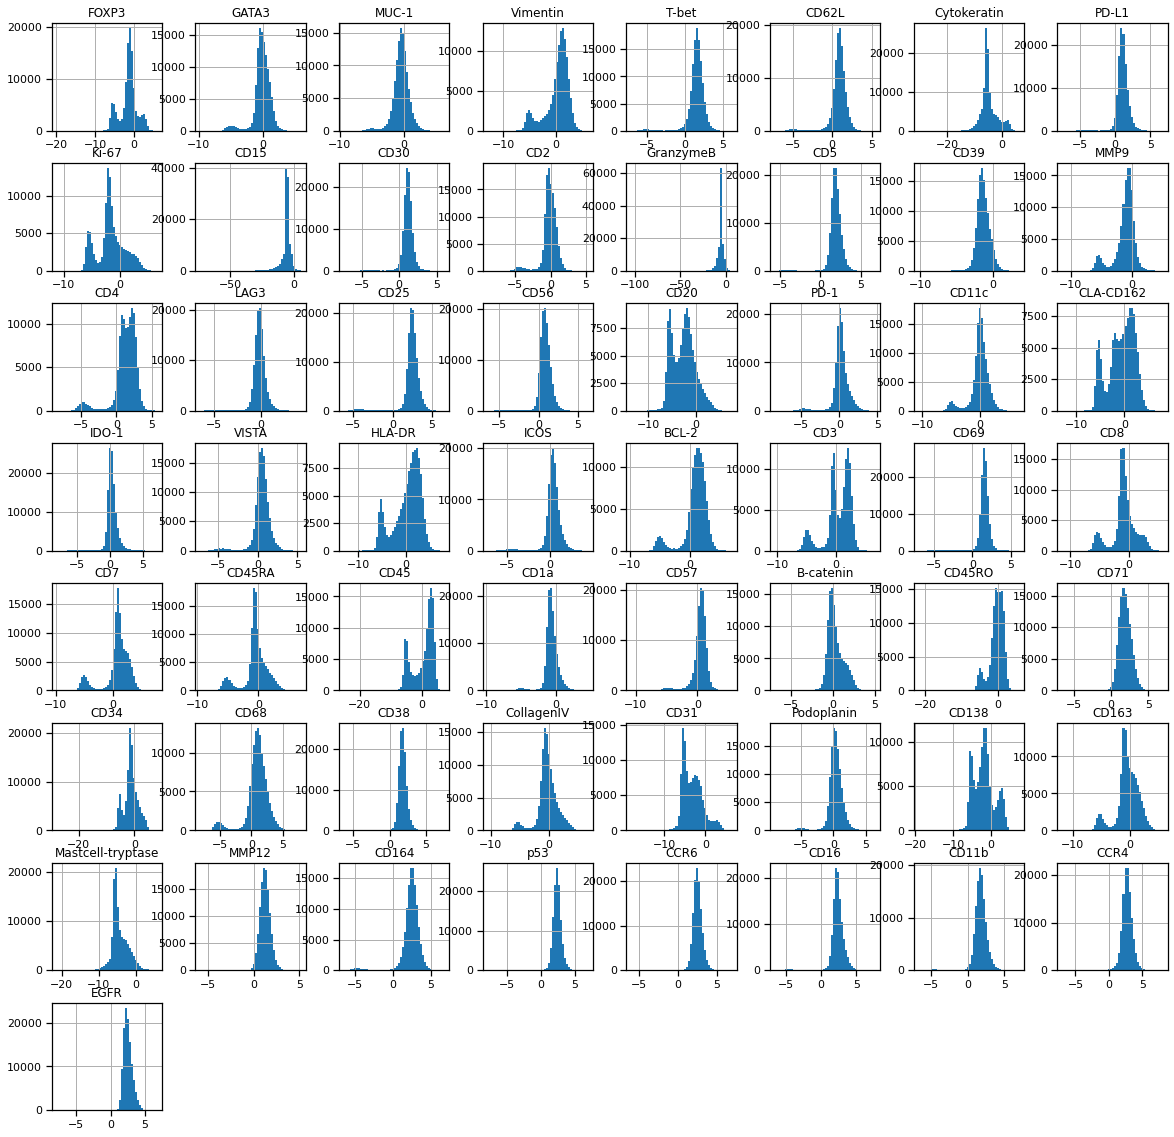

In [107]:
X = obj[aggreg_vars].values
X[X == 0] = X.max() / 100000

X_clr = cs.clr(cs.closure(X))
aggreg_vars_clr = obj[aggreg_vars].copy()
aggreg_vars_clr.loc[:, :] = X_clr
aggreg_vars_clr.hist(bins=50, figsize=(20, 20));

In [108]:
file_path = nas_dir / f'aggregation_statistics.csv'

if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Computing Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [109]:
embedding, reducer = mosna.get_reducer(
    data=var_aggreg, 
    save_dir=nas_dir,
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean', 
    min_dist=0.0,
    )

Computing dimensionality reduction


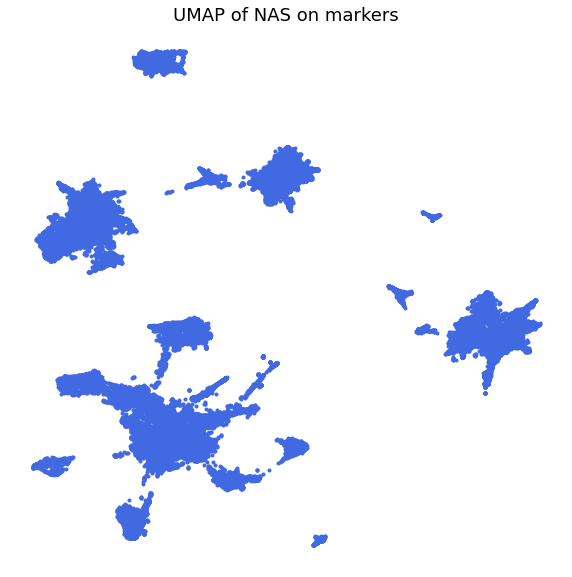

In [110]:
mosna.plot_clusters(embedding)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Leinden clustering

In [60]:
import igraph as ig
import leidenalg as la

In [111]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.005,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Performing clustering
Loading reducer object and reduced coordinates
Found 20 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

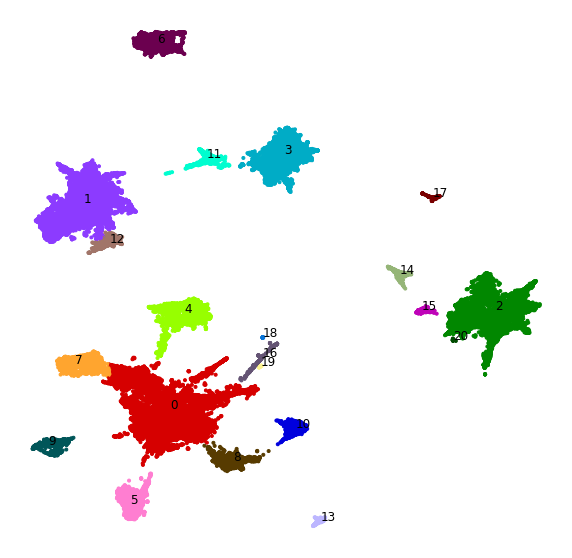

In [112]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap')
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

  0%|          | 0/4 [00:00<?, ?it/s]


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Computing dimensionality reduction


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Computing dimensionality reduction


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates




 25%|██▌       | 1/4 [11:24<34:13, 684.56s/it]


Performing clustering
Computing dimensionality reduction
Found 22 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 21 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 21 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 21 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 21 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 21 clusters
Loading reducer object and reduced coordinates




 50%|█████     | 2/4 [15:47<14:32, 436.36s/it]


Performing clustering
Computing dimensionality reduction
Found 17 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates




 75%|███████▌  | 3/4 [20:06<05:55, 355.69s/it]


Performing clustering
Computing dimensionality reduction
Found 21 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1949: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  



Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


Loading clusterer object and cluster labels
There are 20 clusters
Loading reducer object and reduced coordinates


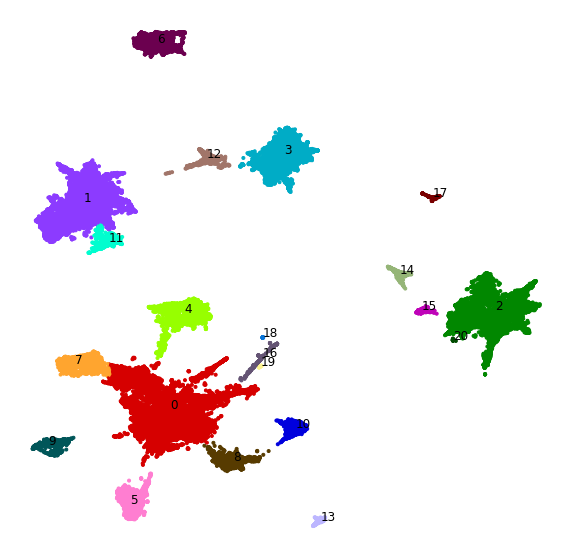

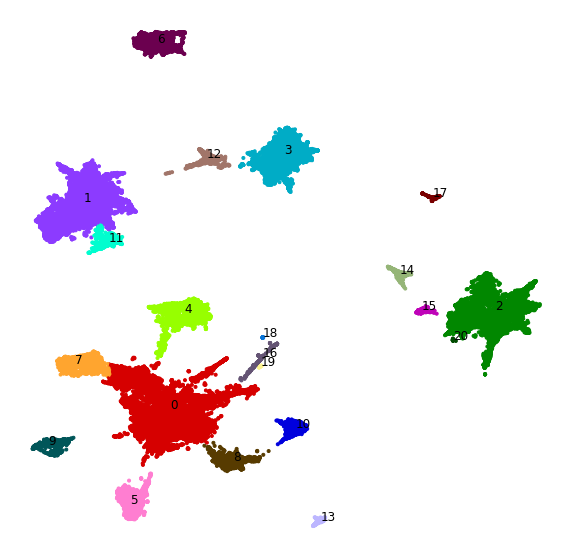

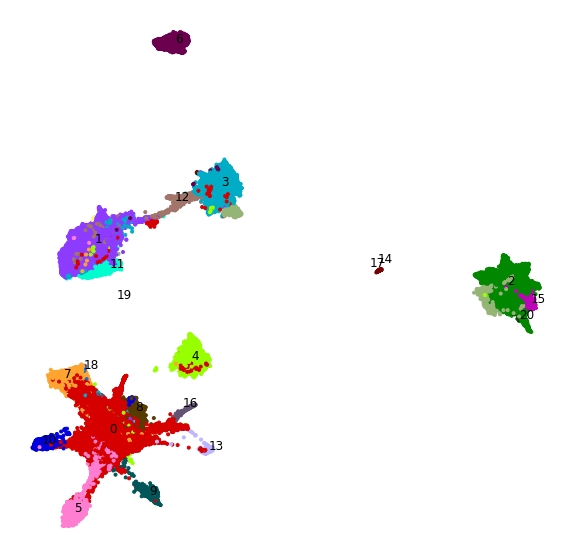

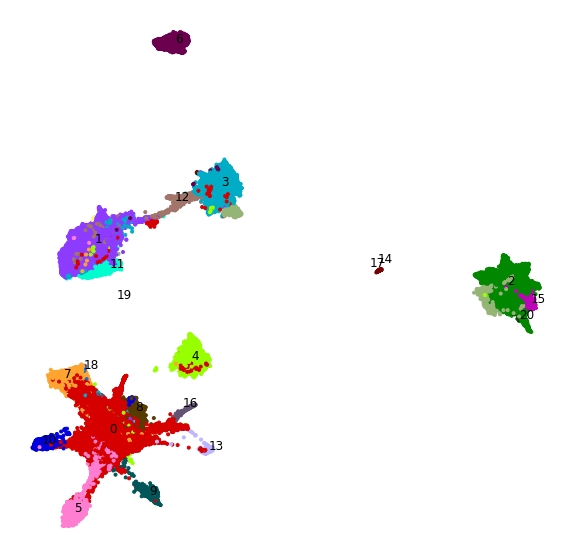

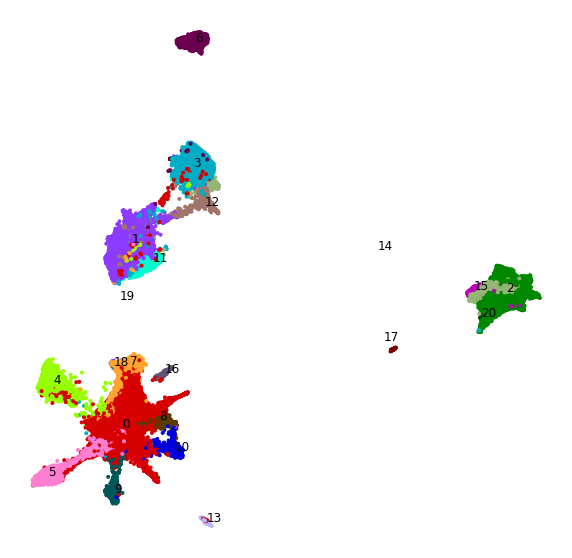

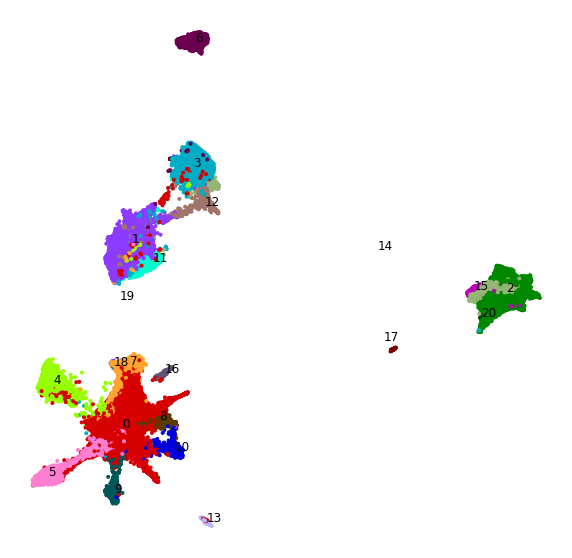

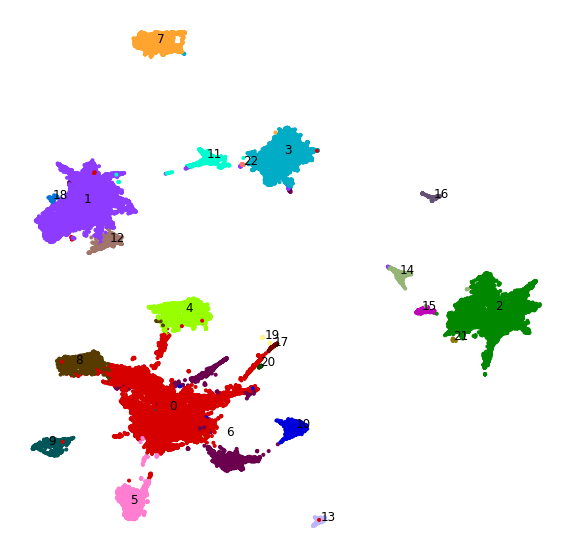

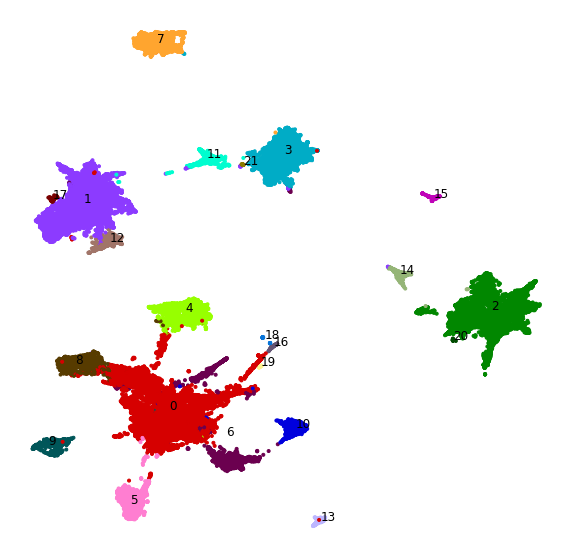

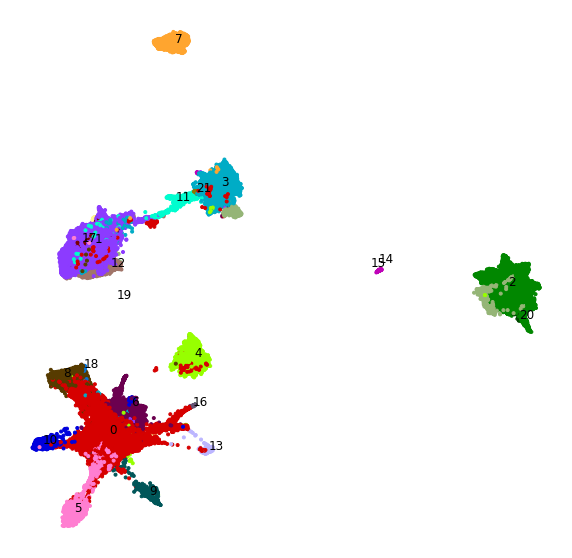

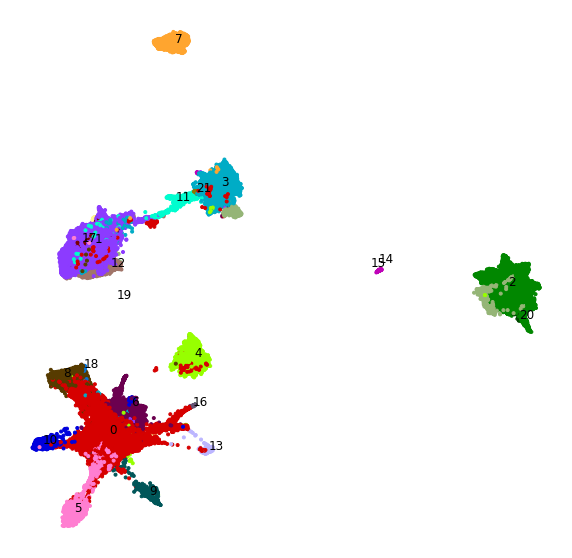

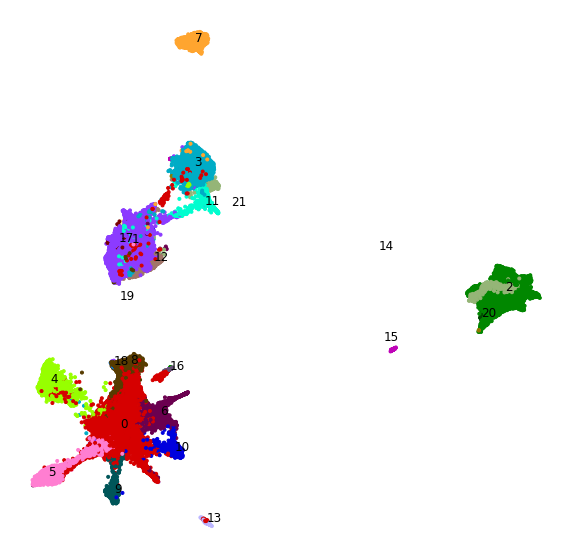

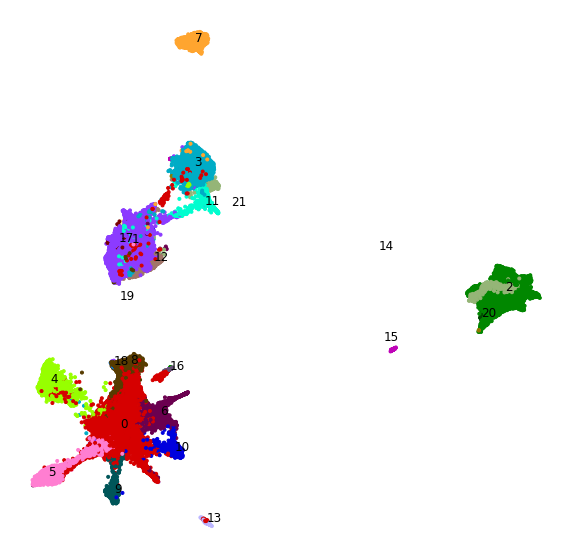

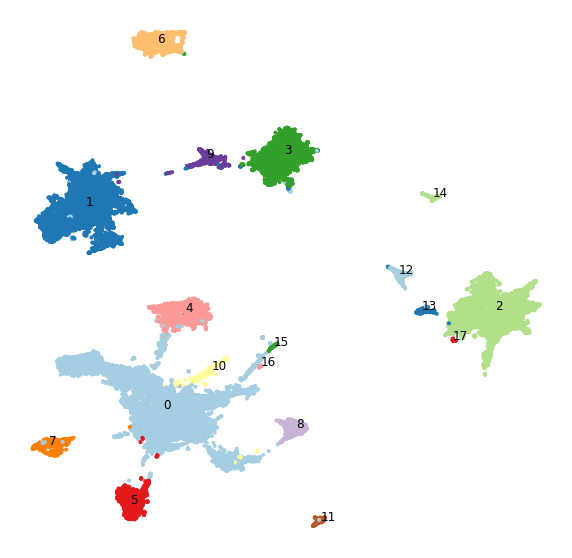

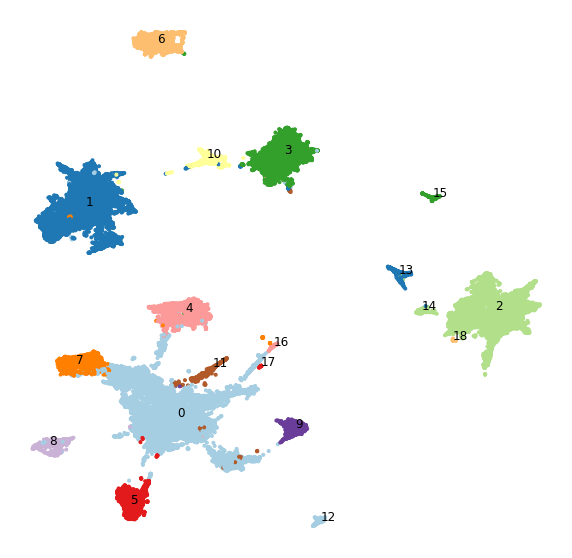

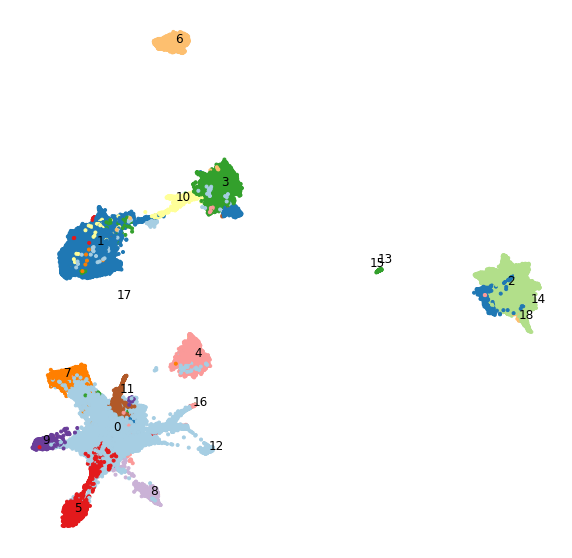

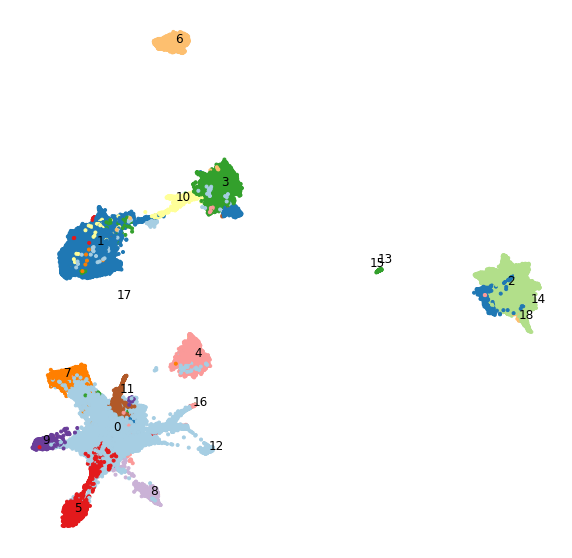

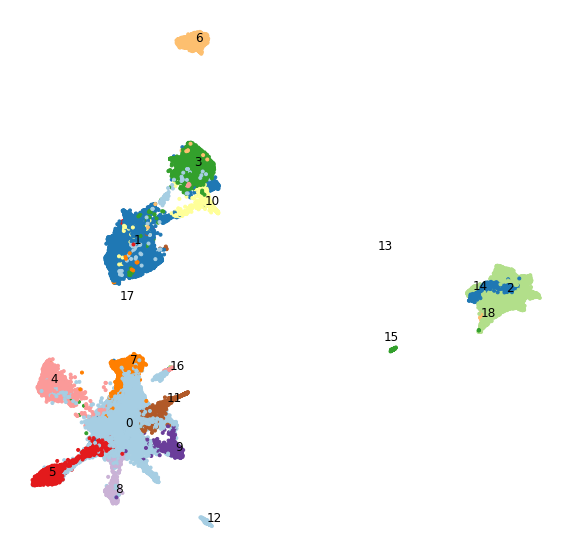

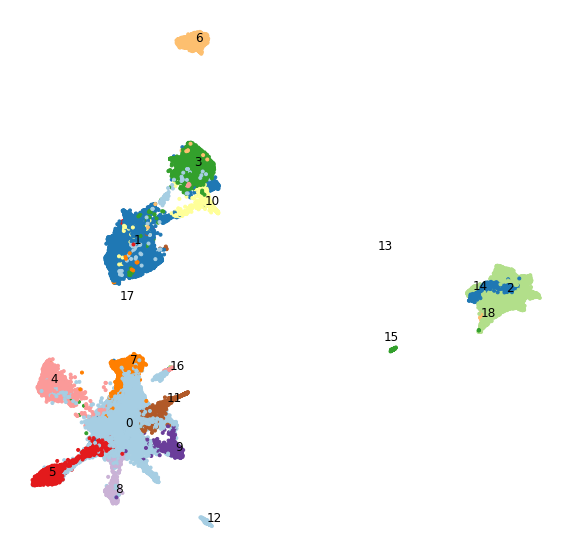

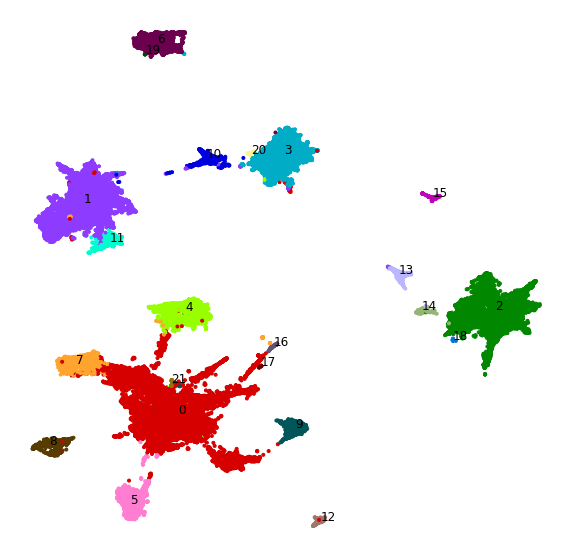

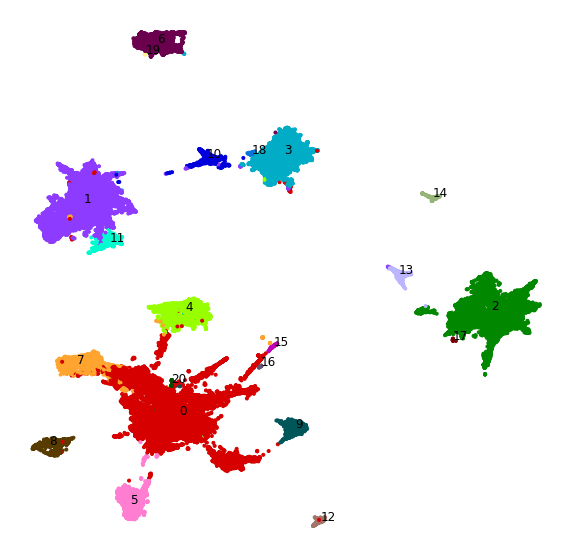

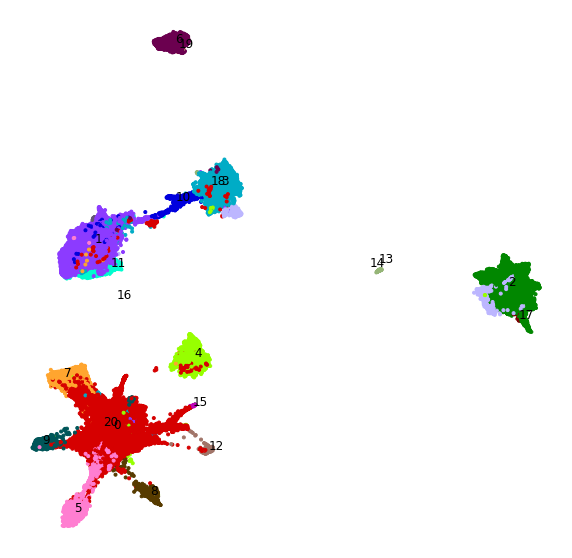

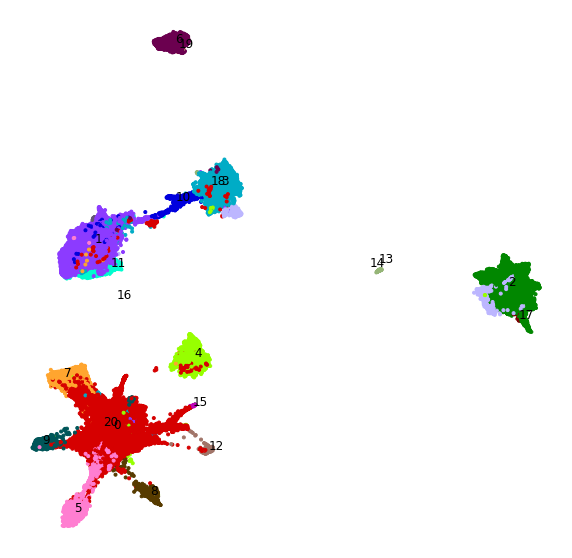

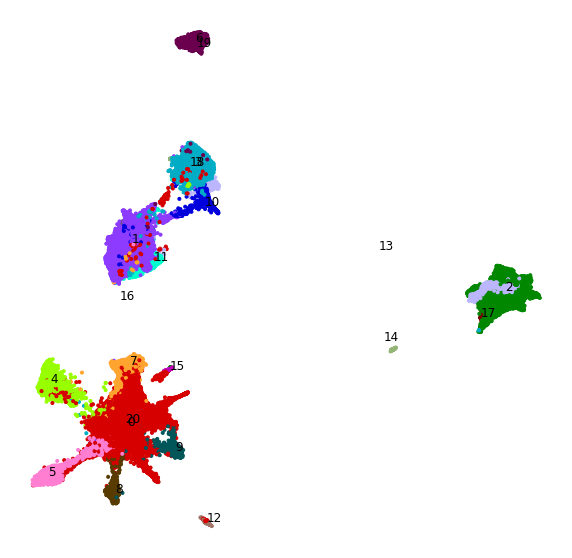

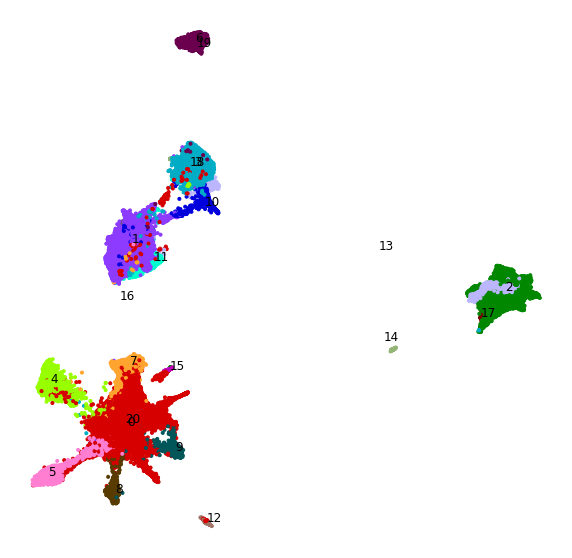

In [116]:
for dim_clust in tqdm([2, 3, 4, 5], leave=False):
    for n_neighbors in tqdm([15, 75, 100], leave=False):
        for k_cluster in tqdm([15, 50], leave=False):
            cluster_params = {
                'reducer_type': 'umap', 
                'n_neighbors': n_neighbors, 
                'metric': 'euclidean', 
                'min_dist': 0.0,
                'clusterer_type': 'leiden', 
                'dim_clust': dim_clust, 
                'k_cluster': 15, 
                'resolution_parameter': 0.005,
            }

            cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)
            embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=n_neighbors)
            mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

In [69]:
# Merge some small adjacent clusters
# merge_dict = {
#     19: 18,
#     21: 17,
#     24: 1,
#     # 23: 1,
#     # 25: 1,
# }
merge_dict = {
    20: 2,
    18: 16,
    19: 16,
    # 23: 1,
    # 25: 1,
}
for old, new in merge_dict.items():
    cluster_labels[cluster_labels == old] = new
    
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)


In [70]:
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)
decreasing_counts_ids = np.argsort(class_count)[::-1]
new_ids = np.arange(len(class_id))[decreasing_counts_ids]
for old, new in zip(class_id, new_ids):
    cluster_labels[cluster_labels == old] = new

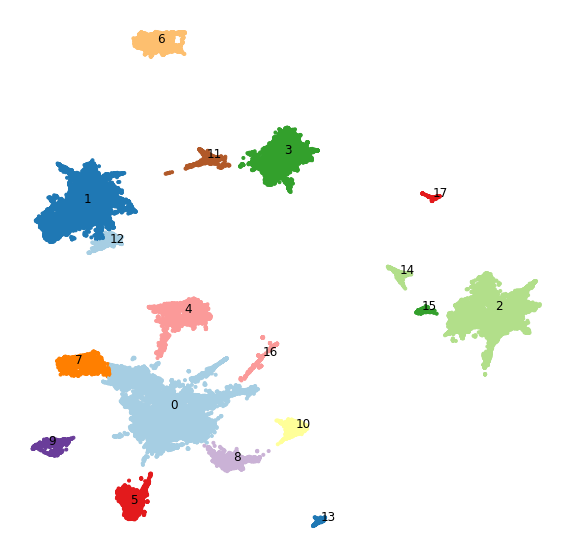

In [94]:
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params, extra_str='_manual_merge')

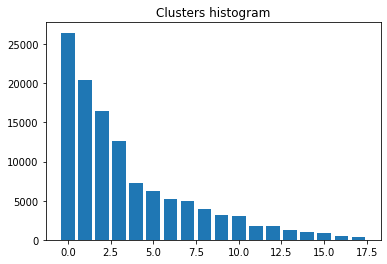

In [32]:
class_id, class_count = np.unique(cluster_labels, return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

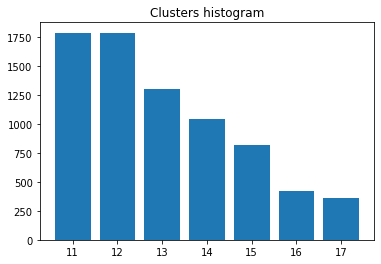

In [33]:
class_id, class_count = np.unique(cluster_labels[cluster_labels > 10], return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

In [34]:
other_str = '_manual-cleaning'

clusterer_name = f"partition-{'RBConfigurationVertexPartition'}_resolution-{resolution_parameter}{other_str}"
file_path = cluster_dir / clusterer_name

# save cluster labels
np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)

#### HDBSCAN clustering

In [65]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl');


Computing dimensionality reduction


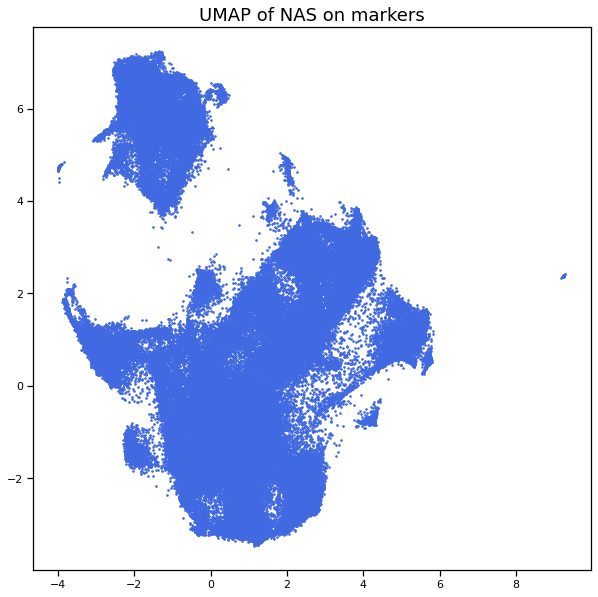

In [66]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [58]:
dim_clust = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = False 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clust-{dim_clust}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if os.path.exists(str(file_path) + '.npy') and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(str(file_path) + '.npy')
    clusterer = joblib.load(str(file_path) + '.pkl')
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, str(file_path) + '.pkl');
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 5.33s


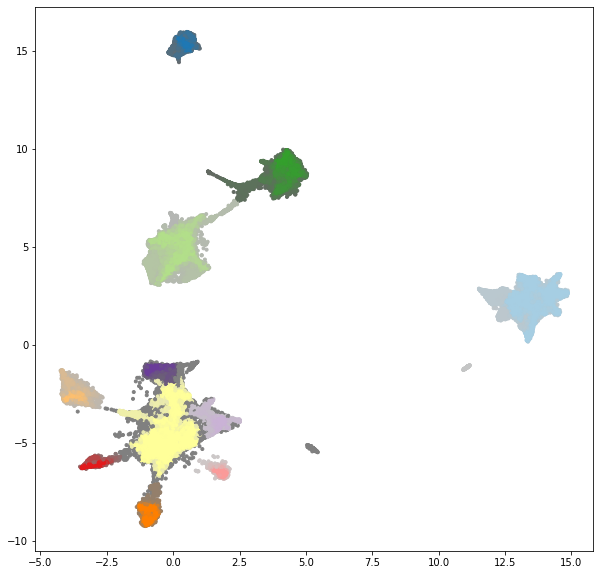

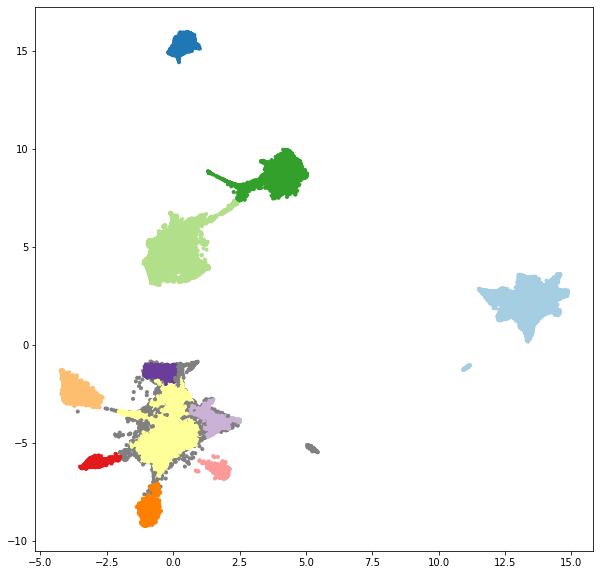

In [59]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in clusterer.labels_]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks good, let's add soft clustering.

In [62]:
dim_clust = 2
min_samples = 10
min_cluster_size = 2000
epsilon = 0.0 # cluster_selection_epsilon=0.0 by default
# soft_clustering = False or 'knn' or 'proba'
soft_clustering = 'knn' 
parallel_clustering = 16
force_recompute = False

cluster_dir = nas_dir / f"clusterer-HDBSCAN_dim_clust-{dim_clust}_min_samples-{min_samples}"   
if not os.path.exists(cluster_dir):
    os.makedirs(cluster_dir)

clusterer_name = f"min_cluster_size-{min_cluster_size}_epsilon-{epsilon}_soft_clustering-{soft_clustering}"
file_path = cluster_dir / clusterer_name
cache_dir = cluster_dir / 'memory_cache'

if os.path.exists(str(file_path) + '.npy') and not force_recompute:
    print("Loading clusterer object and cluster labels")
    cluster_labels = np.load(str(file_path) + '.npy')
    clusterer = joblib.load(str(file_path) + '.pkl')
    nb_clust = cluster_labels.max() # + 1
else:
    print("Performing clustering")
    # select embedded data
    embed_clust = embedding
    # Clustering
    start = time()
    if soft_clustering is False or soft_clustering == 'knn':
        clusterer = hdbscan.HDBSCAN( 
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples,
            cluster_selection_epsilon=epsilon,
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        cluster_labels = clusterer.labels_

        # replace points with label -1 to closest labels in the UMAP space
        if soft_clustering == 'knn':
            cluster_labels = cluster_labels.astype(float)
            # set labels -1 to nan
            select = cluster_labels == -1
            cluster_labels[select] = np.nan
            # perform data imputation
            imputer = KNNImputer(n_neighbors=5, weights="distance")
            cluster_labels = imputer.fit_transform(cluster_labels.reshape(-1, 1)).flatten()
            # set to 0/1 the imputed categorical variables
            cluster_labels = cluster_labels.round().astype(int)
            
    # use max proba of labels different from -1
    # it can lead to very different clustering for unknow reason so far
    elif soft_clustering == 'proba':
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size, 
            min_samples=min_samples, 
            cluster_selection_epsilon=epsilon,
            prediction_data=True, 
            core_dist_n_jobs=parallel_clustering,
            memory=cache_dir.as_posix(),
        )
        clusterer.fit(embed_clust)
        soft_clusters = hdbscan.all_points_membership_vectors(clusterer)
        if len(soft_clusters.shape) > 1:
            # set to 0 the probability of being noise
            if -1 in np.unique(clusterer.labels_):
                soft_clusters[:, 0] = 0
            cluster_labels = soft_clusters.argmax(axis=1)
        else:
            cluster_labels = soft_clusters

    end = time()
    duration = end - start
    nb_clust = cluster_labels.max() # + 1
    print("HDBSCAN has detected {} clusters in {:.2f}s".format(nb_clust, duration))
    # save cluster labels
    np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(clusterer, str(file_path) + '.pkl'.as_posix());
nb_clust = cluster_labels.max() # + 1

Performing clustering
HDBSCAN has detected 10 clusters in 17.62s


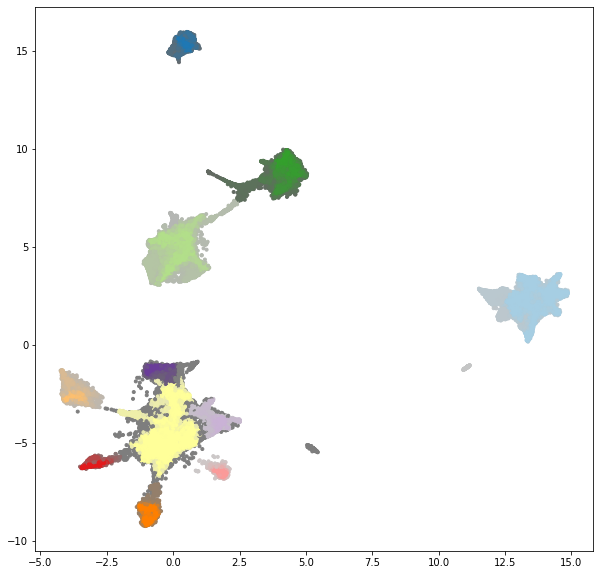

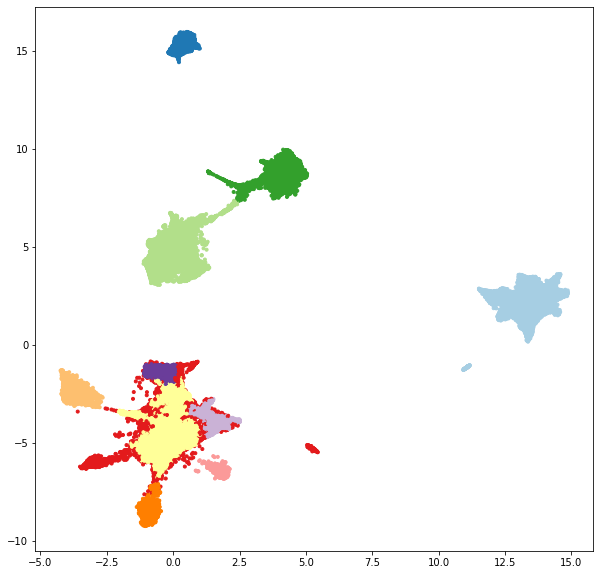

In [63]:
embed_viz = embedding

# make a cohort-wide cmap
clusters_cmap = cc.palette["glasbey_category10"]
# make color mapper
# series to sort by decreasing order
uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
n_colors = len(clusters_cmap)
labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
# make list of colors
labels_colors = [labels_color_mapper[x] for x in cluster_labels]
labels_colors = pd.Series(labels_colors)

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_member_colors, marker='.');

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

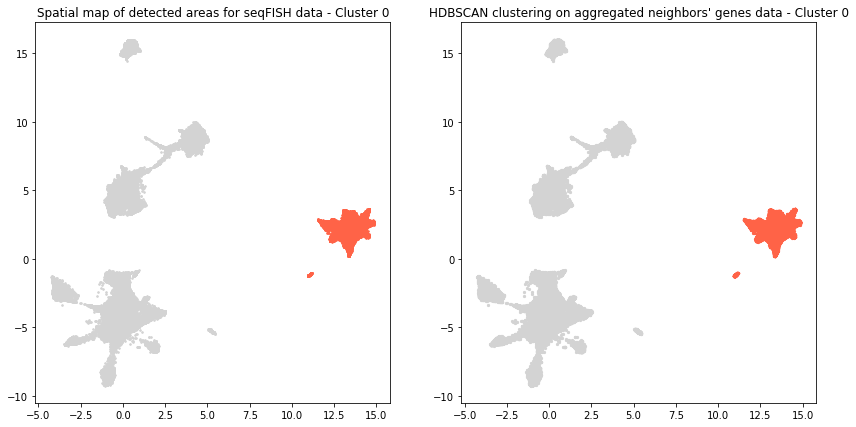

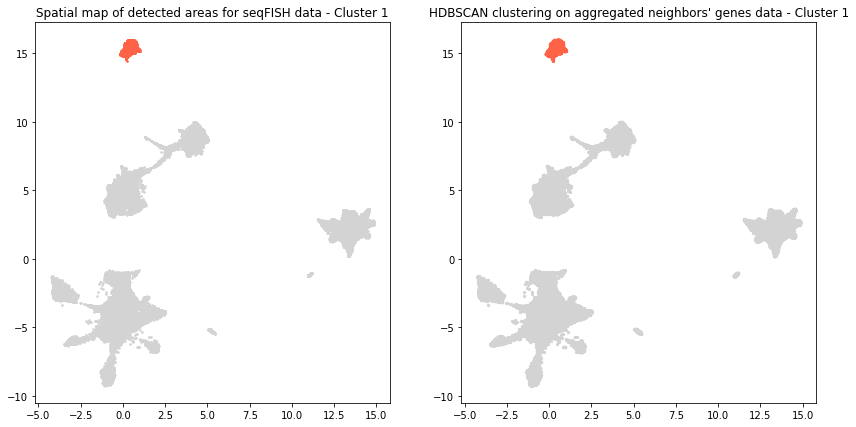

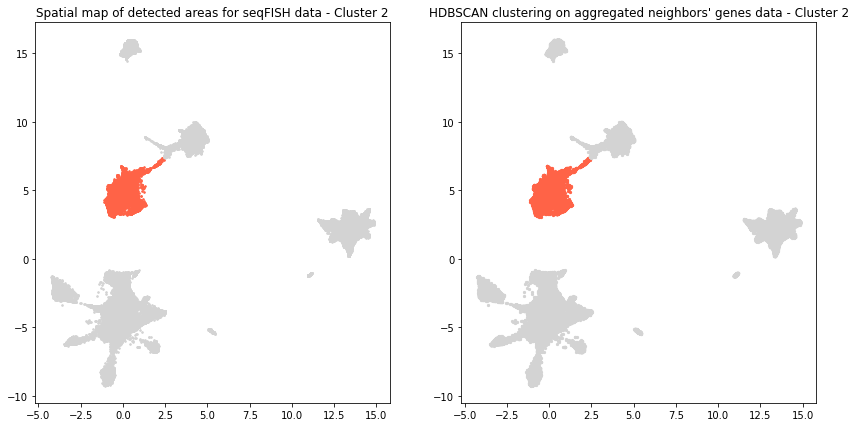

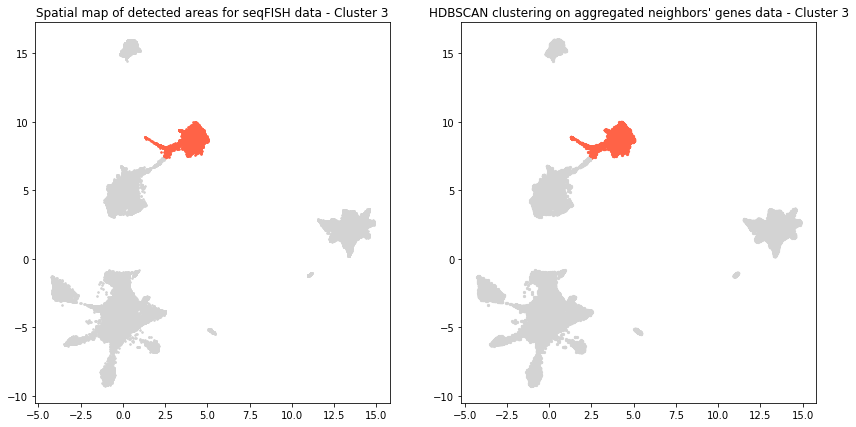

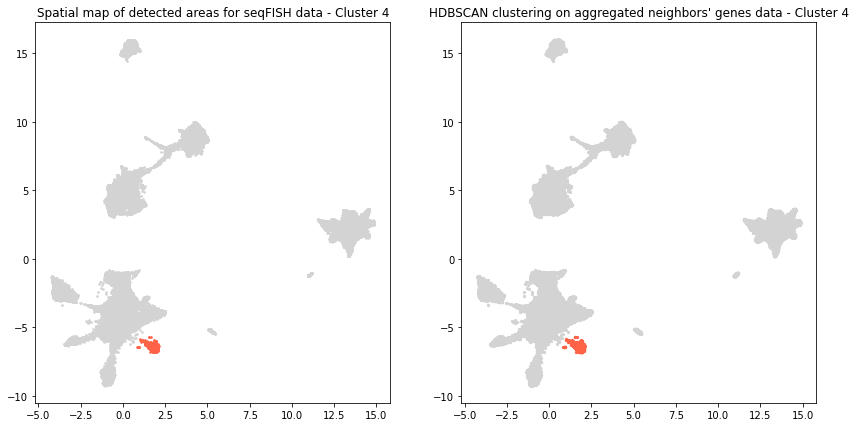

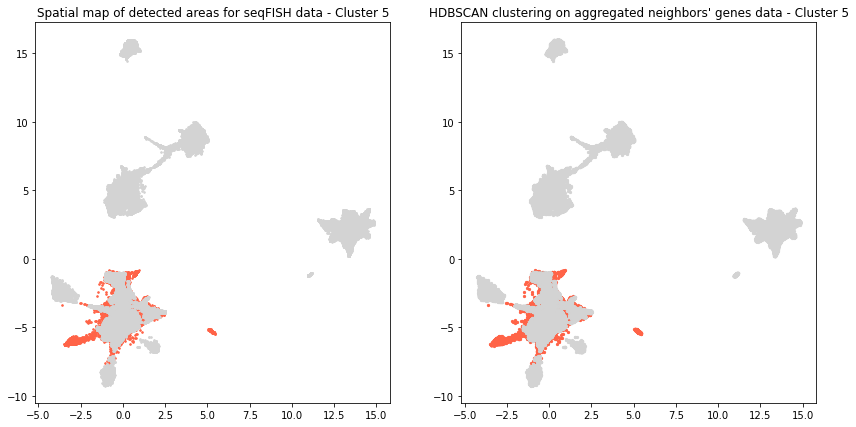

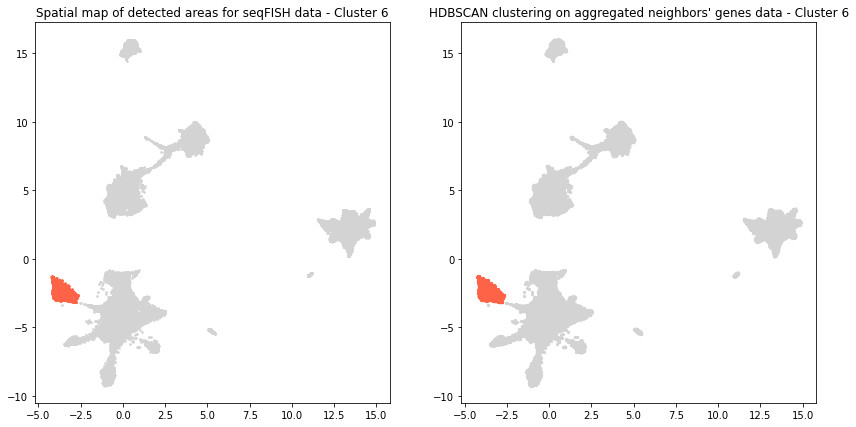

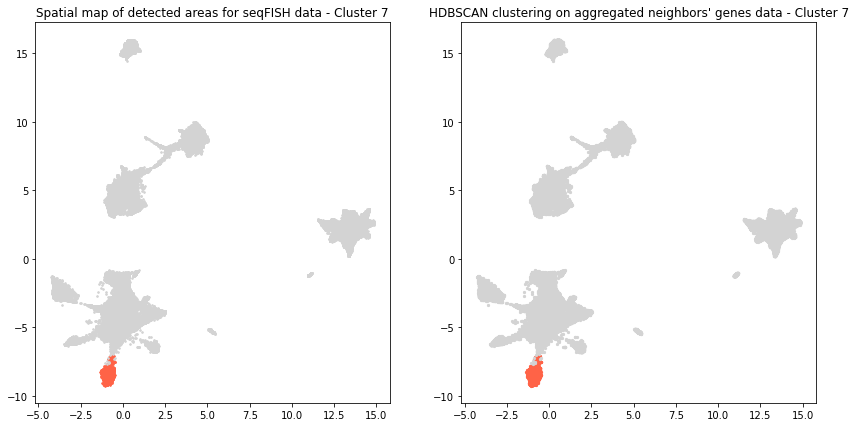

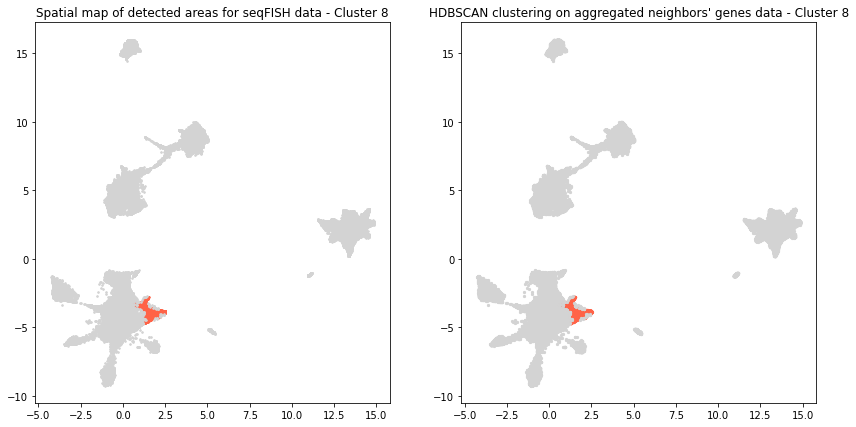

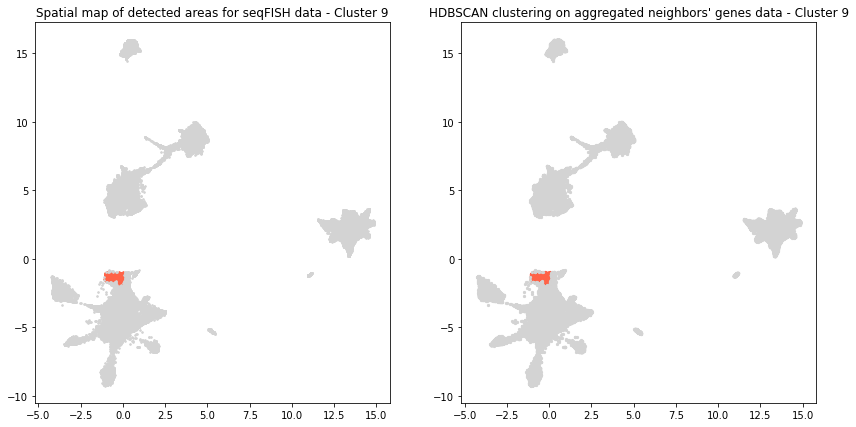

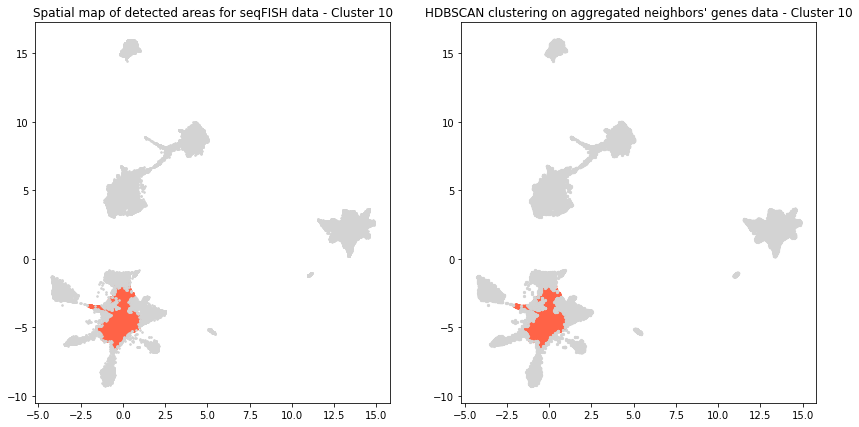

In [64]:
for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id  # cluster of interest (target)
    clust_comp = cluster_labels != clust_id  # cluster(s) we compare with

    fig, ax = plt.subplots(1, 2, figsize=(14,7), tight_layout=False)

    ax[0].scatter(embed_viz[clust_targ,0], embed_viz[clust_targ,1], c='tomato', marker=marker, s=size_points)
    ax[0].scatter(embed_viz[clust_comp,0], embed_viz[clust_comp,1], c='lightgrey', marker=marker, s=size_points)
    ax[0].set_title('Spatial map of detected areas for seqFISH data - Cluster '+str(clust_id), fontsize=12);
    
    ax[1].scatter(embed_viz[clust_targ, 0], embed_viz[clust_targ, 1], s=5, c='tomato');
    ax[1].scatter(embed_viz[clust_comp, 0], embed_viz[clust_comp, 1], s=5, c='lightgrey');
    ax[1].set_title("HDBSCAN clustering on aggregated neighbors' genes data - Cluster "+str(clust_id), fontsize=12);
    plt.show()

It seems impossible to ave a partition that makes sense, there are really wrong cluster labeling.

#### Leiden clustering using Scanpy

In [78]:
# Leiden requires an iGraph object
# we could use a network produced by UMAP
# but it's more straightforward to use Scanpy

import anndata as ad
import scanpy as sc

adata = ad.AnnData(X_clr)
adata.var_names = aggreg_vars
adata

/tmp/ipykernel_19796/2195255581.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X_clr)


AnnData object with n_obs × n_vars = 117170 × 57

In [ ]:
# Computing the neighborhood graph
sc.pp.neighbors(adata)
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

In [ ]:
# Embedding the neighborhood graph
sc.tl.umap(adata)

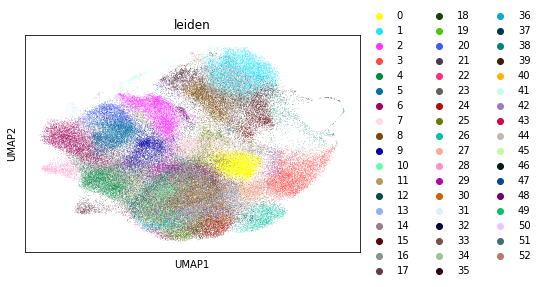

In [ ]:
# Clustering the neighborhood graph
sc.tl.leiden(adata, resolution=2)
sc.pl.umap(adata, color=['leiden'])

The UMAP projected data doesn't look promising.  
Let's try our own UMAP projection.

#### Leiden clustering using scikit knn on UMAP data

In [30]:
import igraph as ig
import leidenalg as la

k_cluster = 15
nas_coords = embedding
nas_pairs = ty.build_knn(nas_coords, k=k_cluster)

G = ty.to_iGraph(nas_coords, nas_pairs, attributes=None)

partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=0.01)
# partition = la.find_partition(G, la.CPMVertexPartition, resolution_parameter=0.00001)
cluster_labels = np.array(partition.membership)
nb_clust = cluster_labels.max()
print(f"Found {nb_clust} clusters")

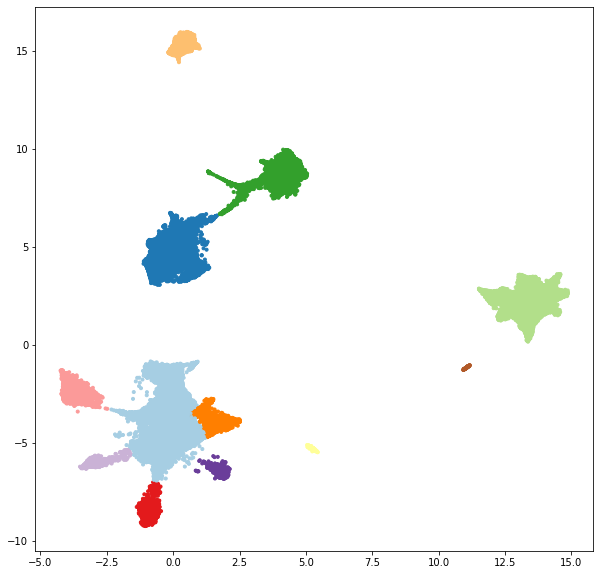

In [65]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks great, we'll do the same with n_neighbors=15, see above.

#### On markers, order 2

In [40]:
order = 2
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

file_path = nas_dir / f'aggregation_statistics.csv'
if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Compouting Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [ ]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl');

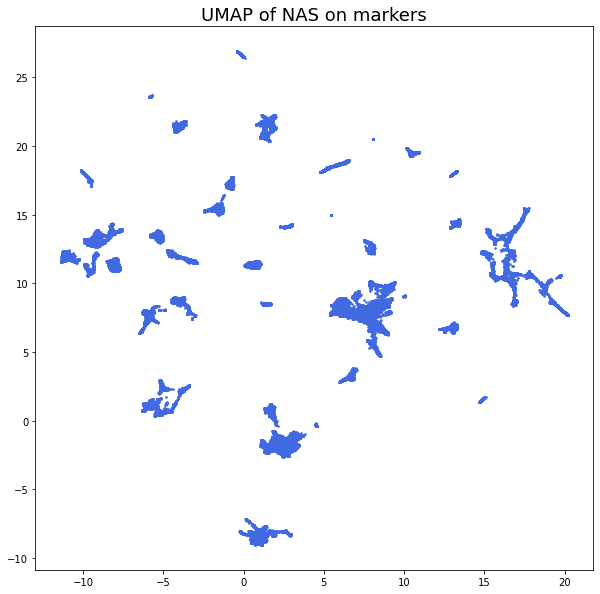

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [45]:
n_neighbors = 100
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl')

Computing dimensionality reduction


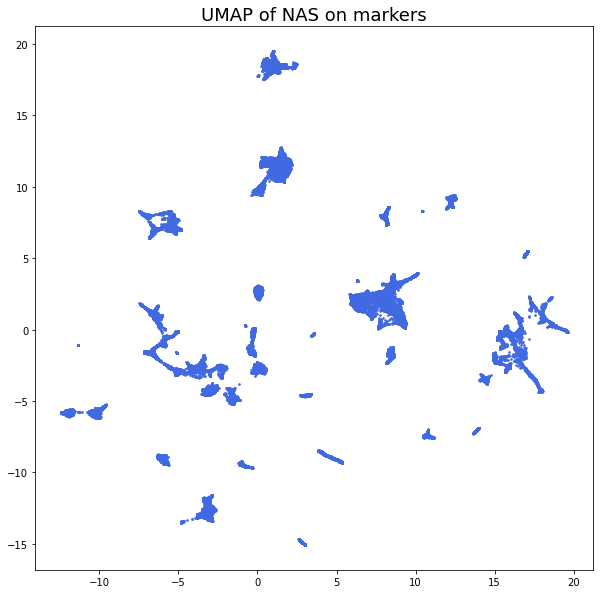

In [46]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

## Survival analysis

We use labels from the Leiden clustering.

In [72]:
cell_types = nodes_all['CellCluster']
niches = cluster_labels

Text(0.5, 1.0, 'niche cell-types composition, normalized by cell-type')

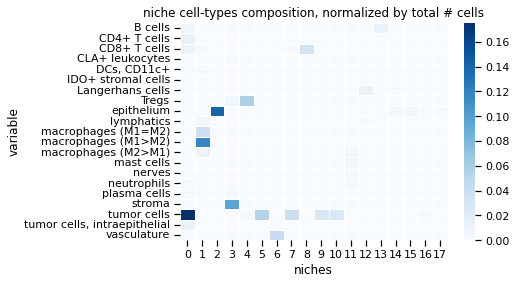

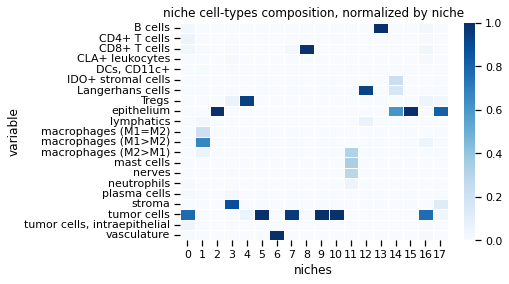

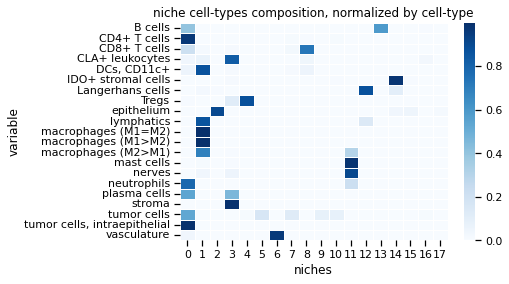

In [73]:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
plt.title("niche cell-types composition, normalized by total # cells")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
plt.title("niche cell-types composition, normalized by cell-type")

In [74]:
# proportion of cells in niches per sample
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='obs')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.224443  0.243659  0.046887  0.262106  0.146042  0.000000   
reg002    0.265060  0.301205  0.009466  0.259897  0.100688  0.000000   
reg003    0.340611  0.179913  0.056769  0.142358  0.089083  0.000000   
reg004    0.232215  0.218792  0.009396  0.220134  0.075168  0.000000   
reg005    0.410714  0.125000  0.017857  0.428571  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.170455  0.328283  0.012626  0.154040  0.095960  0.000000   
reg067    0.143365  0.082346  0.055983  0.045320  0.013922  0.000592   
reg068    0.060548  0.127651  0.007713  0.082530  0.011955  0.000000   
reg069    0.290773  0.145923  0.153433  0.185622  0.018240  0.000000   
reg070    0.165618  0.314465  0.004193  0.345912  0.020964  0.002096   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    0.002306  0.001537  0.003843  0.000000  0.000000  0.026134   
reg002    0.004303  0.000861  0.022375  0.000000  0.000430  0.018933   
reg003    0.059389  0.000000  0.087336  0.000000  0.000873  0.027948   
reg004    0.100671  0.000000  0.103356  0.009396  0.000000  0.022819   
reg005    0.008929  0.000000  0.000000  0.000000  0.000000  0.008929   
...            ...       ...       ...       ...       ...       ...   
reg066    0.050505  0.001263  0.011364  0.000000  0.002525  0.031566   
reg067    0.024882  0.000592  0.096860  0.000000  0.482820  0.007109   
reg068    0.019283  0.000000  0.100270  0.000000  0.551099  0.008484   
reg069    0.064378  0.000000  0.055794  0.000000  0.000000  0.035408   
reg070    0.113208  0.000000  0.008386  0.000000  0.000000  0.020964   

niches          12        13        14   15        16        17  
variable                                                         
reg001    0.007686  0.016910  0.016910  0.0  0.001537  0.000000  
reg002    0.002151  0.004733  0.008176  0.0  0.001721  0.000000  
reg003    0.007860  0.002620  0.000000  0.0  0.003493  0.001747  
reg004    0.008054  0.000000  0.000000  0.0  0.000000  0.000000  
reg005    0.000000  0.000000  0.000000  0.0  0.000000  0.000000  
...            ...       ...       ...  ...       ...       ...  
reg066    0.026515  0.000000  0.114899  0.0  0.000000  0.000000  
reg067    0.000592  0.008294  0.020735  0.0  0.008294  0.008294  
reg068    0.001157  0.005013  0.021211  0.0  0.001157  0.001928  
reg069    0.015021  0.000000  0.000000  0.0  0.002146  0.033262  
reg070    0.004193  0.000000  0.000000  0.0  0.000000  0.000000  

[69 rows x 18 columns]

In [75]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [76]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.244751  0.272432  0.028177  0.261001  0.123365  0.000000   
         3       0.286413  0.199352  0.033082  0.181246  0.082125  0.000000   
2        1       0.321725  0.296849  0.008292  0.286899  0.000000  0.000000   
         3       0.022324  0.137571  0.045829  0.093831  0.015758  0.000000   
3        2       0.260230  0.138661  0.408908  0.103624  0.000468  0.000000   
         4       0.192274  0.112916  0.499566  0.067104  0.035242  0.000250   
4        2       0.329204  0.100617  0.303838  0.118416  0.000000  0.000000   
         4       0.208093  0.159674  0.184550  0.206879  0.057628  0.000000   
5        1       0.008651  0.024554  0.897337  0.040733  0.000000  0.000000   
         3       0.079255  0.164727  0.049015  0.474864  0.042672  0.000000   
6        2       0.298468  0.231711  0.002929  0.180552  0.038170  0.000000   
         4       0.272946  0.172749  0.171870  0.110741  0.105719  0.000203   
7        2       0.007782  0.081712  0.000000  0.385214  0.000000  0.000000   
         4       0.065039  0.137916  0.188097  0.376608  0.016244  0.000000   
8        2       0.397576  0.203194  0.065837  0.194692  0.006749  0.000302   
         4       0.107562  0.142994  0.016928  0.045167  0.011116  0.613301   
9        1       0.293393  0.114404  0.260883  0.201023  0.000000  0.000000   
         3       0.267164  0.120678  0.022540  0.156758  0.008333  0.000148   
10       1       0.072653  0.234286  0.263673  0.226122  0.000000  0.000000   
         3       0.069096  0.262718  0.294609  0.180714  0.003037  0.000000   
11       1       0.118993  0.146777  0.207181  0.307381  0.001810  0.000000   
         3       0.039735  0.070640  0.205298  0.357616  0.019868  0.000000   
12       2       0.240139  0.172568  0.272837  0.094124  0.058122  0.000000   
         4       0.182534  0.222688  0.045785  0.053330  0.038576  0.098171   
13       1       0.183320  0.091175  0.512076  0.112094  0.000000  0.000000   
         3       0.287843  0.151950  0.123107  0.135656  0.045252  0.000520   
14       2       0.297023  0.161303  0.123503  0.081199  0.204111  0.000000   
         4       0.215980  0.260050  0.019405  0.055387  0.133120  0.000000   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.003304  0.001199  0.013109  0.000000  0.000215  0.022533   
         3       0.080030  0.000000  0.095346  0.004698  0.000437  0.025383   
2        1       0.028192  0.000000  0.008292  0.000000  0.000000  0.013267   
         3       0.037673  0.000178  0.003043  0.596485  0.000271  0.024040   
3        2       0.020973  0.000000  0.021483  0.000000  0.000214  0.011882   
         4       0.026010  0.001202  0.030881  0.000000  0.000000  0.010479   
4        2       0.060862  0.000394  0.013665  0.000000  0.000000  0.006832   
         4       0.087159  0.000830  0.063492  0.000000  0.000243  0.024610   
5        1       0.017890  0.000000  0.000896  0.000000  0.000000  0.005067   
         3       0.109622  0.000000  0.005413  0.007993  0.000000  0.018439   
6        2       0.053726  0.000403  0.140047  0.000000  0.000604  0.008287   
         4       0.047313  0.022288  0.043527  0.000097  0.000106  0.020294   
7        2       0.105058  0.000000  0.000000  0.000000  0.000000  0.416342   
         4       0.169487  0.001241  0.004963  0.000000  0.000000  0.032961   
8        2       0.067205  0.000174  0.005664  0.038059  0.000000  0.014233   
         4       0.011203  0.001067  0.032523  0.000000  0.000105  0.004822   
9        1       0.086401  0.000487  0.016441  0.000000  0.000000  0.019434   
         3       0.070376  0.000148  0.056685  0.000000  0.259913  0.014962   
10       1       0.105306  0.001633  0.032653  0.000000  0.000000  0.0163

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


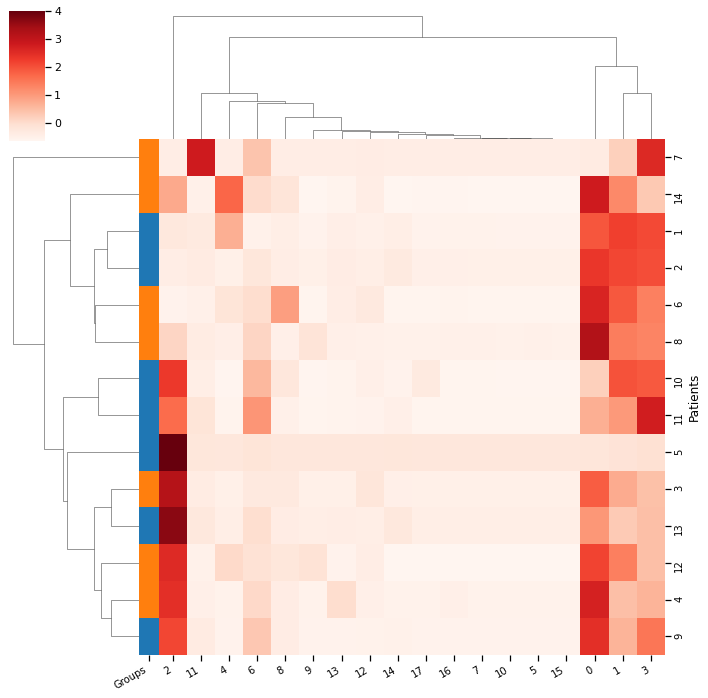

In [79]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

extra_str = ''
resolution_parameter = cluster_params['resolution_parameter']
figname = f"resolution-{resolution_parameter}{extra_str}_biclustering_normalized-obs.png"
plt.savefig(cluster_dir / figname)

In [80]:
# proportion of cells in niches per sample, normalized per niche total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='niche')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.011032  0.015439  0.003718  0.026884  0.026352  0.000000   
reg002    0.023273  0.034093  0.001341  0.047619  0.032455  0.000000   
reg003    0.014735  0.010033  0.003962  0.012851  0.014147  0.000000   
reg004    0.006536  0.007939  0.000427  0.012930  0.007767  0.000000   
reg005    0.001738  0.000682  0.000122  0.003784  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.005100  0.012663  0.000610  0.009618  0.010541  0.000000   
reg067    0.018286  0.013540  0.011520  0.012062  0.006519  0.000322   
reg068    0.005932  0.016121  0.001219  0.016872  0.004300  0.000000   
reg069    0.010239  0.006624  0.008716  0.013639  0.002358  0.000000   
reg070    0.002985  0.007306  0.000122  0.013009  0.001387  0.000161   

niches          6         7         8         9         10        11  \
variable                                                               
reg001    0.000578  0.000408  0.001269  0.000000  0.000000  0.019005   
reg002    0.001926  0.000408  0.013195  0.000000  0.000323  0.024595   
reg003    0.013095  0.000000  0.025374  0.000000  0.000323  0.017887   
reg004    0.014443  0.000000  0.019538  0.002219  0.000000  0.009503   
reg005    0.000193  0.000000  0.000000  0.000000  0.000000  0.000559   
...            ...       ...       ...       ...       ...       ...   
reg066    0.007703  0.000204  0.002284  0.000000  0.000646  0.013974   
reg067    0.016176  0.000408  0.082974  0.000000  0.526316  0.013415   
reg068    0.009628  0.000000  0.065973  0.000000  0.461414  0.012297   
reg069    0.011554  0.000000  0.013195  0.000000  0.000000  0.018446   
reg070    0.010399  0.000000  0.001015  0.000000  0.000000  0.005590   

niches          12        13        14   15        16        17  
variable                                                         
reg001    0.006109  0.016897  0.021012  0.0  0.004717  0.000000  
reg002    0.003054  0.008449  0.018147  0.0  0.009434  0.000000  
reg003    0.005498  0.002304  0.000000  0.0  0.009434  0.005587  
reg004    0.003665  0.000000  0.000000  0.0  0.000000  0.000000  
reg005    0.000000  0.000000  0.000000  0.0  0.000000  0.000000  
...            ...       ...       ...  ...       ...       ...  
reg066    0.012828  0.000000  0.086915  0.0  0.000000  0.000000  
reg067    0.001222  0.021505  0.066858  0.0  0.066038  0.078212  
reg068    0.001833  0.009985  0.052531  0.0  0.007075  0.013966  
reg069    0.008552  0.000000  0.000000  0.0  0.004717  0.086592  
reg070    0.001222  0.000000  0.000000  0.0  0.000000  0.000000  

[69 rows x 18 columns]

In [81]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [82]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.017153  0.024766  0.002530  0.037252  0.029404  0.000000   
         3       0.010635  0.008986  0.002194  0.012890  0.010957  0.000000   
2        1       0.007330  0.008718  0.000305  0.013639  0.000000  0.000000   
         3       0.002191  0.014490  0.007497  0.015650  0.005340  0.000000   
3        2       0.021195  0.014660  0.053730  0.017305  0.000139  0.000000   
         4       0.016265  0.012395  0.068816  0.011392  0.010818  0.000081   
4        2       0.018853  0.007330  0.027520  0.014388  0.000000  0.000000   
         4       0.014206  0.013321  0.020358  0.028106  0.013939  0.000000   
5        1       0.000170  0.000609  0.027825  0.001577  0.000000  0.000000   
         3       0.001625  0.004359  0.001676  0.019868  0.003259  0.000000   
6        2       0.027146  0.027153  0.000427  0.034335  0.012344  0.000000   
         4       0.025946  0.021040  0.025418  0.021977  0.036755  0.000081   
7        2       0.000076  0.001023  0.000000  0.007805  0.000000  0.000000   
         4       0.000850  0.001924  0.004206  0.008869  0.000693  0.000000   
8        2       0.026346  0.016056  0.006867  0.023205  0.001757  0.000054   
         4       0.012972  0.022339  0.003231  0.011379  0.004901  0.319480   
9        1       0.015037  0.005163  0.031726  0.014231  0.000000  0.000000   
         3       0.015887  0.011409  0.003657  0.019079  0.003017  0.000081   
10       1       0.003363  0.013978  0.019688  0.021839  0.000000  0.000000   
         3       0.003438  0.016852  0.023650  0.018764  0.000555  0.000000   
11       1       0.003873  0.005577  0.013897  0.014467  0.000277  0.000000   
         3       0.000680  0.001559  0.005669  0.012772  0.001248  0.000000   
12       2       0.011108  0.010520  0.026240  0.008160  0.011442  0.000000   
         4       0.009993  0.015220  0.003200  0.006504  0.008183  0.019974   
13       1       0.009313  0.005991  0.045745  0.011511  0.000000  0.000000   
         3       0.016876  0.008239  0.012404  0.008869  0.012644  0.000107   
14       2       0.016057  0.011835  0.013867  0.009264  0.042788  0.000000   
         4       0.025682  0.036717  0.003330  0.007776  0.055513  0.000000   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.001252  0.000408  0.007232  0.000000  0.000161  0.021800   
         3       0.013769  0.000000  0.022456  0.001110  0.000161  0.013695   
2        1       0.003274  0.000000  0.001269  0.000000  0.000000  0.004472   
         3       0.015983  0.000102  0.001903  0.447368  0.000161  0.028508   
3        2       0.008377  0.000000  0.011926  0.000000  0.000161  0.013695   
         4       0.010784  0.000511  0.017381  0.000000  0.000000  0.013136   
4        2       0.017909  0.000102  0.005329  0.000000  0.000000  0.005869   
         4       0.029174  0.000306  0.027404  0.000000  0.000161  0.023197   
5        1       0.001733  0.000000  0.000127  0.000000  0.000000  0.001397   
         3       0.011361  0.000000  0.000761  0.001427  0.000000  0.005590   
6        2       0.024649  0.000204  0.085511  0.000000  0.000484  0.011179   
         4       0.022867  0.011742  0.028039  0.000079  0.000081  0.028228   
7        2       0.005199  0.000000  0.000000  0.000000  0.000000  0.059810   
         4       0.011843  0.000102  0.000507  0.000000  0.000000  0.005869   
8        2       0.019834  0.000068  0.002622  0.015219  0.000000  0.012484   
         4       0.006932  0.000681  0.026812  0.000000  0.000108  0.008571   
9        1       0.016272  0.000204  0.004440  0.000000  0.000000  0.010620   
         3       0.020268  0.000102  0.039457  0.000000  0.247498  0.013974   
10       1       0.024841  0.000408  0.010150  0.000000  0.000000  0.0111

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


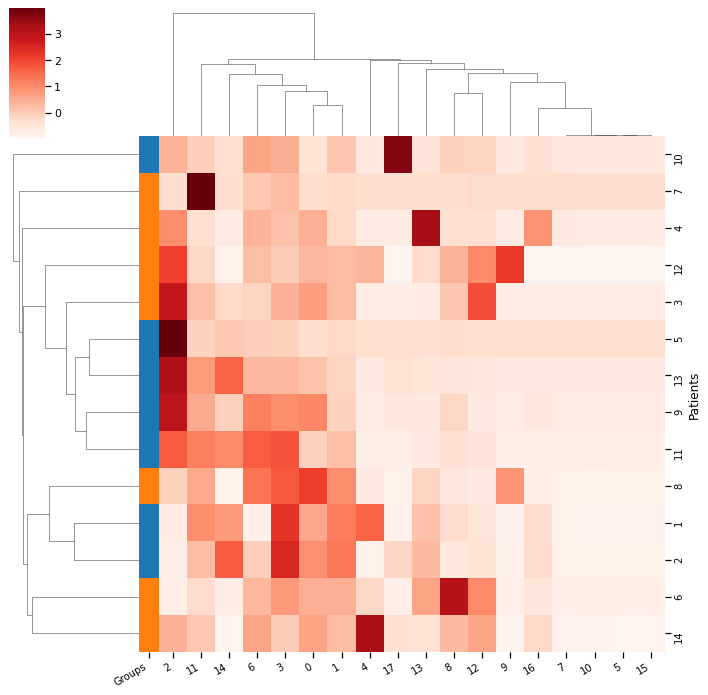

In [83]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-niche.png"
plt.savefig(cluster_dir / figname)

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

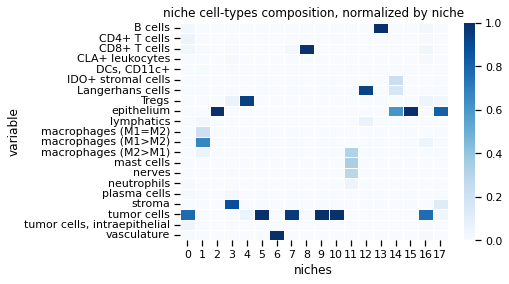

In [84]:
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
# plt.title("niche cell-types composition, normalized by total # cells")
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
# plt.title("niche cell-types composition, normalized by cell-type")

That look just great, but even if the idea that we should also somehow take into account proportions per niche for normalization sounds correct, it doesn't seem right to ignore proportions per patient. For example if we normalize by the total number of cells we obtain again a very different result:

In [85]:
# proportion of cells in niches per sample, normalized per total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='total')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.002492  0.002705  0.000521  0.002910  0.001622  0.000000   
reg002    0.005257  0.005974  0.000188  0.005155  0.001997  0.000000   
reg003    0.003328  0.001758  0.000555  0.001391  0.000871  0.000000   
reg004    0.001476  0.001391  0.000060  0.001400  0.000478  0.000000   
reg005    0.000393  0.000119  0.000017  0.000410  0.000000  0.000000   
...            ...       ...       ...       ...       ...       ...   
reg066    0.001152  0.002219  0.000085  0.001041  0.000649  0.000000   
reg067    0.004131  0.002373  0.001613  0.001306  0.000401  0.000017   
reg068    0.001340  0.002825  0.000171  0.001826  0.000265  0.000000   
reg069    0.002313  0.001161  0.001220  0.001476  0.000145  0.000000   
reg070    0.000674  0.001280  0.000017  0.001408  0.000085  0.000009   

niches          6         7         8        9         10        11        12  \
variable                                                                        
reg001    0.000026  0.000017  0.000043  0.00000  0.000000  0.000290  0.000085   
reg002    0.000085  0.000017  0.000444  0.00000  0.000009  0.000376  0.000043   
reg003    0.000580  0.000000  0.000853  0.00000  0.000009  0.000273  0.000077   
reg004    0.000640  0.000000  0.000657  0.00006  0.000000  0.000145  0.000051   
reg005    0.000009  0.000000  0.000000  0.00000  0.000000  0.000009  0.000000   
...            ...       ...       ...      ...       ...       ...       ...   
reg066    0.000341  0.000009  0.000077  0.00000  0.000017  0.000213  0.000179   
reg067    0.000717  0.000017  0.002791  0.00000  0.013911  0.000205  0.000017   
reg068    0.000427  0.000000  0.002219  0.00000  0.012196  0.000188  0.000026   
reg069    0.000512  0.000000  0.000444  0.00000  0.000000  0.000282  0.000119   
reg070    0.000461  0.000000  0.000034  0.00000  0.000000  0.000085  0.000017   

niches          13        14   15        16        17  
variable                                               
reg001    0.000188  0.000188  0.0  0.000017  0.000000  
reg002    0.000094  0.000162  0.0  0.000034  0.000000  
reg003    0.000026  0.000000  0.0  0.000034  0.000017  
reg004    0.000000  0.000000  0.0  0.000000  0.000000  
reg005    0.000000  0.000000  0.0  0.000000  0.000000  
...            ...       ...  ...       ...       ...  
reg066    0.000000  0.000777  0.0  0.000000  0.000000  
reg067    0.000239  0.000597  0.0  0.000239  0.000239  
reg068    0.000111  0.000469  0.0  0.000026  0.000043  
reg069    0.000000  0.000000  0.0  0.000017  0.000265  
reg070    0.000000  0.000000  0.0  0.000000  0.000000  

[69 rows x 18 columns]

In [86]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [87]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       0.003875  0.004340  0.000354  0.004033  0.001809  0.000000   
         3       0.002402  0.001575  0.000307  0.001395  0.000674  0.000000   
2        1       0.001656  0.001528  0.000043  0.001476  0.000000  0.000000   
         3       0.000495  0.002539  0.001050  0.001694  0.000329  0.000000   
3        2       0.004788  0.002569  0.007523  0.001873  0.000009  0.000000   
         4       0.003674  0.002172  0.009636  0.001233  0.000666  0.000004   
4        2       0.004259  0.001284  0.003853  0.001558  0.000000  0.000000   
         4       0.003209  0.002334  0.002851  0.003043  0.000858  0.000000   
5        1       0.000038  0.000107  0.003896  0.000171  0.000000  0.000000   
         3       0.000367  0.000764  0.000235  0.002151  0.000201  0.000000   
6        2       0.006132  0.004758  0.000060  0.003717  0.000760  0.000000   
         4       0.005861  0.003687  0.003559  0.002379  0.002262  0.000004   
7        2       0.000017  0.000179  0.000000  0.000845  0.000000  0.000000   
         4       0.000192  0.000337  0.000589  0.000960  0.000043  0.000000   
8        2       0.005951  0.002814  0.000962  0.002512  0.000108  0.000003   
         4       0.002930  0.003915  0.000452  0.001232  0.000302  0.016927   
9        1       0.003397  0.000905  0.004442  0.001540  0.000000  0.000000   
         3       0.003589  0.001999  0.000512  0.002065  0.000186  0.000004   
10       1       0.000760  0.002449  0.002757  0.002364  0.000000  0.000000   
         3       0.000777  0.002953  0.003311  0.002031  0.000034  0.000000   
11       1       0.000875  0.000977  0.001946  0.001566  0.000017  0.000000   
         3       0.000154  0.000273  0.000794  0.001383  0.000077  0.000000   
12       2       0.002509  0.001843  0.003674  0.000883  0.000704  0.000000   
         4       0.002257  0.002667  0.000448  0.000704  0.000504  0.001058   
13       1       0.002104  0.001050  0.006405  0.001246  0.000000  0.000000   
         3       0.003812  0.001444  0.001737  0.000960  0.000778  0.000006   
14       2       0.003627  0.002074  0.001942  0.001003  0.002633  0.000000   
         4       0.005801  0.006434  0.000466  0.000842  0.003416  0.000000   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.000055  0.000017  0.000243  0.000000  0.000004  0.000333   
         3       0.000610  0.000000  0.000755  0.000030  0.000004  0.000209   
2        1       0.000145  0.000000  0.000043  0.000000  0.000000  0.000068   
         3       0.000708  0.000004  0.000064  0.012042  0.000004  0.000435   
3        2       0.000371  0.000000  0.000401  0.000000  0.000004  0.000209   
         4       0.000478  0.000021  0.000585  0.000000  0.000000  0.000201   
4        2       0.000794  0.000004  0.000179  0.000000  0.000000  0.000090   
         4       0.001293  0.000013  0.000922  0.000000  0.000004  0.000354   
5        1       0.000077  0.000000  0.000004  0.000000  0.000000  0.000021   
         3       0.000504  0.000000  0.000026  0.000038  0.000000  0.000085   
6        2       0.001092  0.000009  0.002876  0.000000  0.000013  0.000171   
         4       0.001013  0.000491  0.000943  0.000002  0.000002  0.000431   
7        2       0.000230  0.000000  0.000000  0.000000  0.000000  0.000913   
         4       0.000525  0.000004  0.000017  0.000000  0.000000  0.000090   
8        2       0.000879  0.000003  0.000088  0.000410  0.000000  0.000191   
         4       0.000307  0.000028  0.000902  0.000000  0.000003  0.000131   
9        1       0.000721  0.000009  0.000149  0.000000  0.000000  0.000162   
         3       0.000898  0.000004  0.001327  0.000000  0.006542  0.000213   
10       1       0.001101  0.000017  0.000341  0.000000  0.000000  0.0001

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


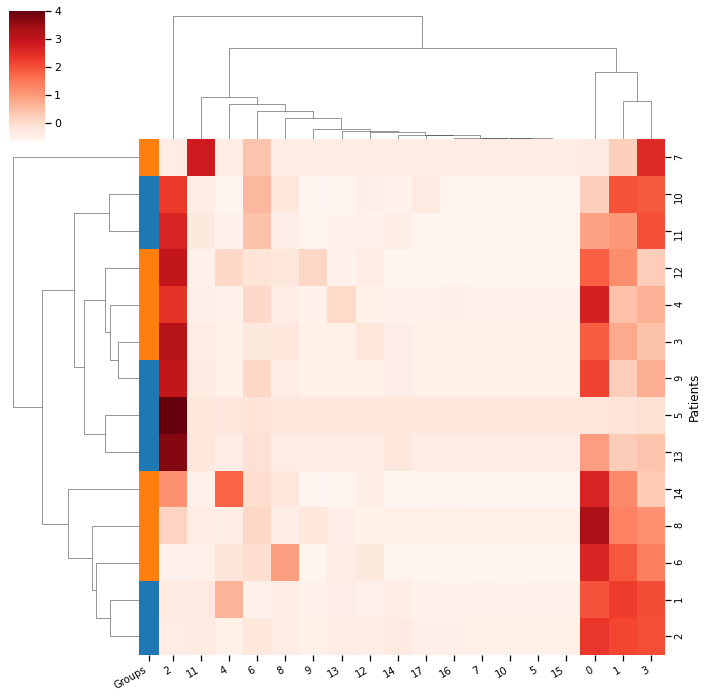

In [88]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-total.png"
plt.savefig(cluster_dir / figname)

A more statistically sound way to take jointly into account proportions per variable and per observation is the Central Log Ratio, that we already applied to protein composition:

In [89]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='clr')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    4.314273  4.396421  2.748393  4.469402  3.884544 -5.003713   
reg002    4.621660  4.749493  1.289455  4.601987  3.653734 -5.442820   
reg003    4.596888  3.958617  2.805128  3.724491  3.255714 -5.010492   
reg004    4.741042  4.681501  1.533661  4.687617  3.613103 -4.053482   
reg005    5.643238  4.453654  2.507744  5.685798 -1.826636 -1.826636   
...            ...       ...       ...       ...       ...       ...   
reg066    3.938085  4.593492  1.335396  3.836832  3.363544 -4.608422   
reg067    3.083791  2.529327  2.143453  1.932144  0.751854 -2.405147   
reg068    2.928660  3.674532  0.868146  3.238390  1.306401 -5.768819   
reg069    4.697464  4.008000  4.058190  4.248637  1.928559 -4.545887   
reg070    4.551508  5.192696  0.875208  5.288006  2.484646  0.182061   

niches          6         7         8         9         10        11  \
variable                                                               
reg001   -0.263868 -0.669333  0.246958 -5.003713 -5.003713  2.163880   
reg002    0.500998 -1.108440  2.149657 -5.442820 -1.801587  1.982603   
reg003    2.850249 -5.010492  3.235911 -5.010492 -1.369259  2.096477   
reg004    3.905239 -4.053482  3.931556  1.533661 -4.053482  2.420964   
reg005    1.814597 -1.826636 -1.826636 -1.826636 -1.826636  1.814597   
...            ...       ...       ...       ...       ...       ...   
reg066    2.721690 -0.967189  1.230035 -4.608422 -0.274042  2.251686   
reg067    1.332523 -2.405147  2.691666 -6.739527  4.298041  0.079760   
reg068    1.784437 -5.768819  3.433095 -5.768819  5.137144  0.963456   
reg069    3.189690 -4.545887  3.046589 -4.545887 -4.545887  2.591853   
reg070    4.171045 -3.459172  1.568355 -3.459172 -3.459172  2.484646   

niches          12        13        14        15        16        17  
variable                                                              
reg001    0.940105  1.728562  1.728562 -5.003713 -0.669333 -5.003713  
reg002   -0.192149  0.596308  1.142852 -5.442820 -0.415293 -5.442820  
reg003    0.827966 -0.270647 -5.010492 -5.010492  0.017035 -0.676112  
reg004    1.379510 -4.053482 -4.053482 -4.053482 -4.053482 -4.053482  
reg005   -1.826636 -1.826636 -1.826636 -1.826636 -1.826636 -1.826636  
...            ...       ...       ...       ...       ...       ...  
reg066    2.077333 -4.608422  3.543670 -4.608422 -4.608422 -4.608422  
reg067   -2.405147  0.233911  1.150201 -6.739527  0.233911  0.233911  
reg068   -1.028974  0.437363  1.879747 -5.768819 -1.028974 -0.518148  
reg069    1.734403 -4.545887 -4.545887 -4.545887 -0.211507  2.529333  
reg070    0.875208 -3.459172 -3.459172 -3.459172 -3.459172 -3.459172  

[69 rows x 18 columns]

In [90]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [91]:
counts_clinic

0         1         2         3         4         5  \
Patients Groups                                                               
1        1       4.467967  4.572957  2.018924  4.535695  3.769139 -5.223266   
         3       4.668965  4.320059  2.169395  4.206054  3.434408 -4.531987   
2        1       4.868917  4.788445  1.210497  4.754351 -4.040174 -4.040174   
         3       1.872789  3.820708  2.386464  3.393807  1.684307 -5.506114   
3        2       5.483931  4.849269  5.935860  4.545842 -0.840228 -4.481461   
         4       4.690993  4.157998  5.643741  3.566736  2.986900 -3.190343   
4        2       5.437850  4.248648  5.349520  4.410801 -4.403620 -4.403620   
         4       4.585361  4.325150  4.463542  4.588488  3.315385 -4.926901   
5        1       2.622944  3.696235  7.294943  4.141221 -2.463474 -2.463474   
         3       3.180628  3.906345  1.773546  4.931105  2.432533 -4.199406   
6        2       4.914177  4.661552  0.275392  4.407182  1.947411 -5.301441   
         4       4.537672  4.060380  3.930393  3.482130  3.590844 -3.788432   
7        2       2.214999  4.566375 -2.119381  6.116972 -2.119381 -2.119381   
         4       3.430963  4.063796  4.362572  5.154833  2.049694 -3.200977   
8        2       5.481124  4.856136  3.729230  4.771417  1.029310 -3.331209   
         4       3.233886  4.259954  1.784338  3.089442  1.645840  5.706364   
9        1       5.396084  4.258307  4.346142  4.785843 -4.045251 -4.045251   
         3       4.214806  3.685438  1.507982  3.729601  0.848046 -4.279559   
10       1       3.066723  4.237569  4.355739  4.202104 -5.063146 -5.063146   
         3       3.160046  4.495625  4.610192  4.121457  0.035481 -4.992046   
11       1       4.173673  4.433956  2.937301  5.085307 -1.250317 -3.764081   
         3       2.866607  3.441972  4.508835  5.063832  2.173460 -3.664997   
12       2       4.638594  4.319767  4.714289  3.607093  3.245833 -4.670327   
         4       3.671498  3.873697  1.892126  2.376122  2.070463  2.957233   
13       1       5.023393  4.327144  6.036944  4.499036 -4.122957 -4.122957   
         3       4.230063  3.537778  2.767271  2.961448  2.179612 -3.732029   
14       2       4.624241  4.040846  2.431497  3.337496  4.276270 -5.069078   
         4       4.486034  4.989059  0.370791  2.785041  4.234493 -5.144310   

                        6         7         8         9        10        11  \
Patients Groups                                                               
1        1       0.118565 -0.888887  1.198307 -5.223266 -3.402650  2.073241   
         3       3.377744 -4.531987  3.583734 -1.738415 -2.711370  2.258721   
2        1       2.434272 -4.040174  1.210497 -4.040174 -4.040174  1.680501   
         3       2.552797 -3.685497  0.027214  5.344846 -3.685497  2.038467   
3        2       2.864643 -4.481461  2.970124 -4.481461 -2.660845  2.256974   
         4       2.618399 -0.676580  2.857080 -5.010960 -5.010960  1.781582   
4        2       3.748895 -2.583004  2.252955 -4.403620 -4.403620  1.559808   
         4       3.728201 -0.939095  3.396420 -4.926901 -3.106285  2.438207   
5        1       3.374983 -2.463474 -0.642858 -2.463474 -2.463474  2.073638   
         3       3.518789 -4.199406  0.246545 -1.280178 -4.199406  1.724000   
6        2       3.161599 -3.134251  4.157929 -5.301441 -2.931519  1.324145   
         4       2.657958  0.699749  2.648019 -4.698740 -4.698740  1.900627   
7        2       4.817689 -2.119381 -2.119381 -2.119381 -2.119381  6.194681   
         4       4.293338 -1.380360 -0.687213 -3.200977 -3.200977  2.781322   
8        2       3.707925 -3.331209  1.006312  0.674642 -4.544954  2.088661   
         4       1.683743 -2.021025  2.619736 -5.507865 -4.294120  0.810713   
9        1       4.031313 -1.878061  2.437772 -4.045251 -4.045251  2.539034   
         3       2.840734 -4.279559  2.479570 -5.363154  2.518992  1.447897   
10       1       3.437899 -0.728766  2.266966 -5.063146 -5.063146  1.5738

/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1709: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[group_var], inplace=True)


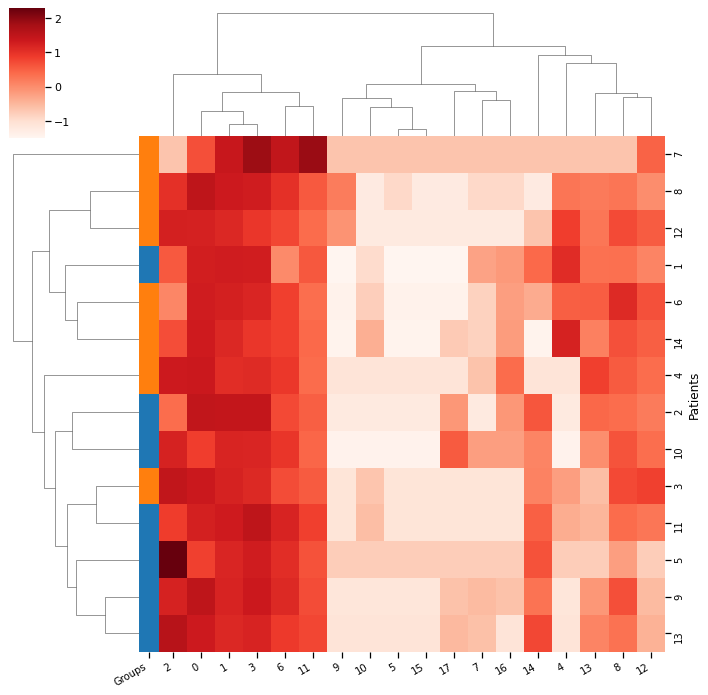

In [92]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-clr.png"
plt.savefig(cluster_dir / figname)

With this more statistically sound way of normalizing data we still obtain a good, although not perfect, blind clustering of patients into responders and non responders.

In [95]:
# the colorbar is just wrong
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = d.style.background_gradient(cmap=cm)
s

In [170]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [171]:
pvals.head(20)

pval  pval_corr
4  0.212121   0.821678
7  0.212121   0.821678
0  0.575175   0.821678
1  0.575175   0.821678
5  0.575175   0.821678
8  0.575175   0.821678
9  0.575175   0.821678
2  0.962704   0.962704
3  0.962704   0.962704
6  0.962704   0.962704

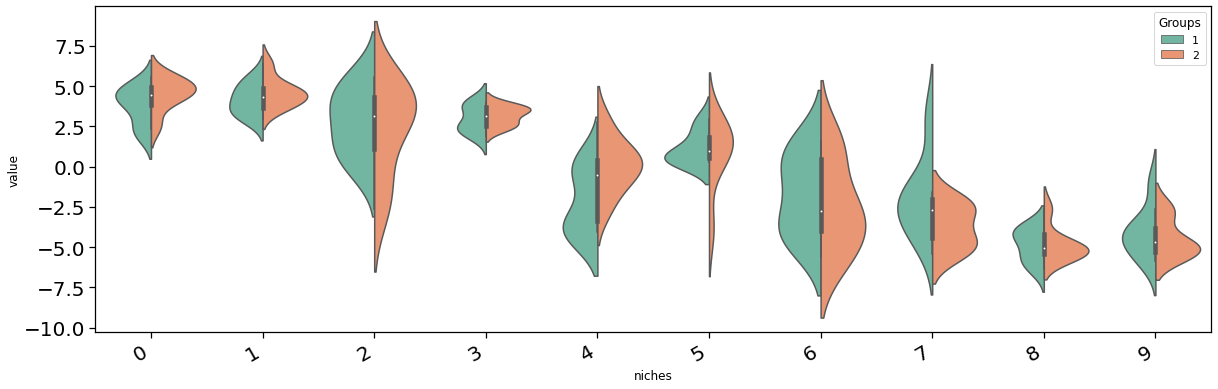

In [172]:
# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

From this plot we would like to add niches 4 and 17 to those that seggregate patients into groups 1 and 2.

In [173]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(coefs.index, coefs)
        plt.xticks(rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")

There is no niche statistically related to response group


##### Elasticnet logistic regression

In [155]:
def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10

In [156]:
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

In [158]:
nas_dir

PosixPath('../data/processed/CODEX_CTCL/all_samples_networks_xy_trim_dist-200_solitary-0/nas_on-markers_stats-mean-std_order-1')







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

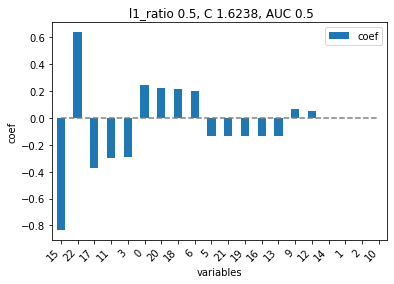

<Figure size 432x288 with 0 Axes>

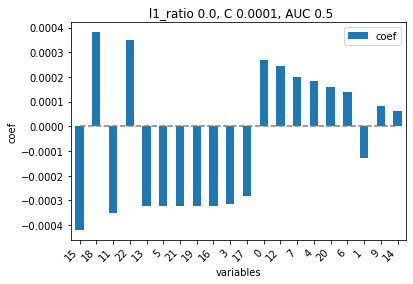

<Figure size 432x288 with 0 Axes>

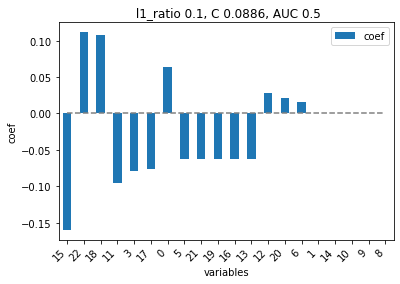

In [163]:
start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

It is quite surprising that the ROC og log reg models are 0.5, whereas we do have statistically different distributions for some variables. To investigate...

In [ ]:
save_dir = cluster_dir / (clusterer_name + "_spatial_networks_figures")
save_dir.mkdir(parents=True, exist_ok=True)

sample_ids = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = np.array([labels_color_mapper[x] for x in cluster_labels])

# colormap for cell-types
n_cell_types = obj['ClusterName'].unique().size
# palette = sns.color_palette(cc.glasbey, n_colors=n_cell_types).as_hex()
palette = [mpl.colors.rgb2hex(x) for x in mpl.cm.get_cmap('tab20').colors]

plots_marker = '.'
for sample in sample_ids:
    print("filename: {}".format(sample))
    select = np.array(obj['FileName'] == sample)

    # load nodes and edges
    coords = obj.loc[select, cell_pos_cols].values
    pairs = edges_all.loc[edges_all['filename'] == sample, ['source', 'target']].values

    # Big summary plot
    fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
    i = 0
    ty.plot_network(coords, pairs, labels=obj.loc[select, 'ClusterName'], cmap_nodes=palette, marker=plots_marker, size_nodes=size_points, ax=ax[0])
    ax[i].set_title('Spatial map of phenotypes', fontsize=14);

    i += 1
    ax[i].scatter(coords[:, 0], coords[:, 1], c=cluster_colors[select], marker=plots_marker, s=size_points)
    ax[i].set_title('Spatial map of detected areas', fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[select, 0], embed_viz[select, 1], c=cluster_colors[select], s=5);
    ax[i].set_title("HDBSCAN clustering on NAS", fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors);
    ax[i].set_title("HDBSCAN clustering on NAS of all samples", fontsize=14);
    ax[i].set_aspect('equal')
    
    # make plot limits equal
    ax[i-1].set_xlim(ax[i].get_xlim())
    ax[i-1].set_ylim(ax[i].get_ylim())

    suptitle = f"Spatial omics data and detected areas - sample {sample}";
    fig.suptitle(suptitle, fontsize=18)

    fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)

#### Explore different clustering wrt survival

In [ ]:
for dim_clust in tqdm([2, 3, 4, 5], leave=False):
    for n_neighbors in tqdm([15, 75, 100], leave=False):
        for k_cluster in tqdm([15, 50], leave=False):
            cluster_params = {
                'reducer_type': 'umap', 
                'n_neighbors': n_neighbors, 
                'metric': 'euclidean', 
                'min_dist': 0.0,
                'clusterer_type': 'leiden', 
                'dim_clust': dim_clust, 
                'k_cluster': 15, 
                'resolution_parameter': 0.005,
            }

            cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

            # Survival analysis (just heatmap for now)
            niches = cluster_labels
            for normalize in ['total', 'niche', 'obs', 'clr']:
                counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
                # merge clinical data and proportion of cells in niches per sample
                counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
                counts_clinic.drop(columns=['Spots'], inplace=True)
                counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

                # plot heatmap
                g = mosna.plot_heatmap(
                    counts_clinic.reset_index(), 
                    obs_labels='Patients', 
                    group_var='Groups', 
                    groups=[1, 2],
                    figsize=(10, 10),
                    z_score=False,
                    cmap=sns.color_palette("Reds", as_cmap=True),
                    )
                str_params = '_'.join([str(key) + '-' + str(val) for key, val in cluster_params.items()])
                figname = f"biclustering_{str_params}_normalized-{normalize}.png"
                plt.savefig(cluster_dir / figname, dpi=150)